In [76]:
using DrWatson
using Pkg
@quickactivate "proteins"
using CSV, DelimitedFiles, HypothesisTests, BSON, Distributions, Random 
using SpinModels, Optim, Parameters, CUDA, LinearAlgebra, Statistics, Printf, Flux
using BenchmarkTools, PyPlot
import StatsBase.countmap
import DrWatson.savename

include( srcdir( "toysector.jl" ) )
include( srcdir( "false_positive_funcs.jl" )  )
include( projectdir("newtoymodel", "fitting.jl") )


initθ (generic function with 3 methods)

In [77]:
function get_froJ(J::AbstractArray{T,4} ,p::Real=2) where T<:Number
    N = size(J,2)
    froJ= [ norm(J[:,i,:,j], p) for i ∈ 1:N, j ∈ 1:N ] 
end

function get_froh(h::AbstractMatrix{T} ,p::Real=2) where T<:Number
    N = size( h,2 )
    froh = [ norm(h[:,i], p) for i ∈ 1:N ]
end

function get_froW(W::AbstractArray{T,3}, p::Real=2) where T<:Number
    P, _, N = size(W)
    froW = [ norm(W[μ,:,i],p) for μ ∈ 1:P, i ∈ 1:N  ]
end

function get_fro(A::AbstractArray, p::Real=2)
    ndims(A) == 2 && return get_froh(A,p)
    ndims(A) == 3 && return get_froW(A,p)
    ndims(A) == 4 && return get_froJ(A,p) 
end

im20(mat)= im20( mat,  begin _, ax = subplots(); ax end )
function im20(mat, ax)
    im = ax.imshow(mat )

    dimy, dimx = size(mat)
    
    stepx = round(dimx/10) == 0 ? 1 : Int(round(dimx/10))
    stepy = round(dimy/10) == 0 ? 1 : Int(round(dimy/10))
    
    # Major ticks
    ax.set_xticks(0:stepx:dimx-1)
    ax.set_yticks(0:stepy:dimy-1)

    # Labels for major ticks
    ax.set_xticklabels(1:stepx:dimx)
    ax.set_yticklabels(1:stepy:dimy)

    # Minor ticks
    ax.set_xticks(-.5:1:dimx, minor=true)
    ax.set_yticks(-.5:1:dimy, minor=true)

    # # Gridlines based on minor ticks
    # minorticks_off()
    (dimx < 50) && (dimy < 50) ? ax.grid(true, which="minor", color="k", linestyle="-", linewidth=1.5) : nothing
#     colorbar()\
    sca(ax)
    tick_params(bottom = false, left = false, which = "both")
    
    return im
end

im35(mat)= im35( mat,  begin _, ax = subplots(); ax end,  )
function im35(mat, ax, cmap="cividis", hideticklabels=false)
    im = ax.imshow(mat, cmap=cmap )

    dimy, dimx = size(mat) 
    stepx = round(dimx/10) == 0 ? 1 : Int(round(dimx/10))
    stepy = round(dimy/10) == 0 ? 1 : Int(round(dimy/10))

    ax.set_xticks([0,9,28,34])
    ax.set_yticks([0,9,28,34])
    ax.set_xticklabels( [1,10,29,35],  fontsize=16 )
    ax.set_yticklabels( [1,10,29,35],  fontsize=16 )
    
    ax.tick_params(bottom = false, left = false, which = "both")
    
    ax.set_xticks(-.5:1:dimx, minor=true)
    ax.set_yticks(-.5:1:dimy, minor=true)
    (dimx < 50) && (dimy < 50) ? ax.grid(true, which="minor", 
        color="k", linestyle="-", linewidth=0.5) : nothing
    
    
    if hideticklabels == false
        ax.xaxis.set_tick_params(labeltop=true)
        ax.xaxis.set_tick_params(labelbottom=false)
    else
        ax.yaxis.set_tick_params(labelleft=false)
        ax.xaxis.set_tick_params(labelbottom=false)
    end
    
   
    
    # Major ticks
    # ax.set_xticks(0:stepx:dimx-1)
    # ax.set_yticks(0:stepy:dimy-1)
    # # Labels for major ticks
    # ax.set_xticklabels(1:stepx:dimx)
    # ax.set_yticklabels(1:stepy:dimy)  
    
    ax.vlines([10,28].-0.5, -0.5, dimy-0.5, colors="white", linewidth=2)
    ax.hlines([10,28].-0.5, -0.5, dimx-0.5, colors="white", linewidth=2)
    return im
end


im35 (generic function with 4 methods)

# Toy model plot

In [78]:
get_fro(θpw.J)

10×10 Matrix{Float32}:
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0

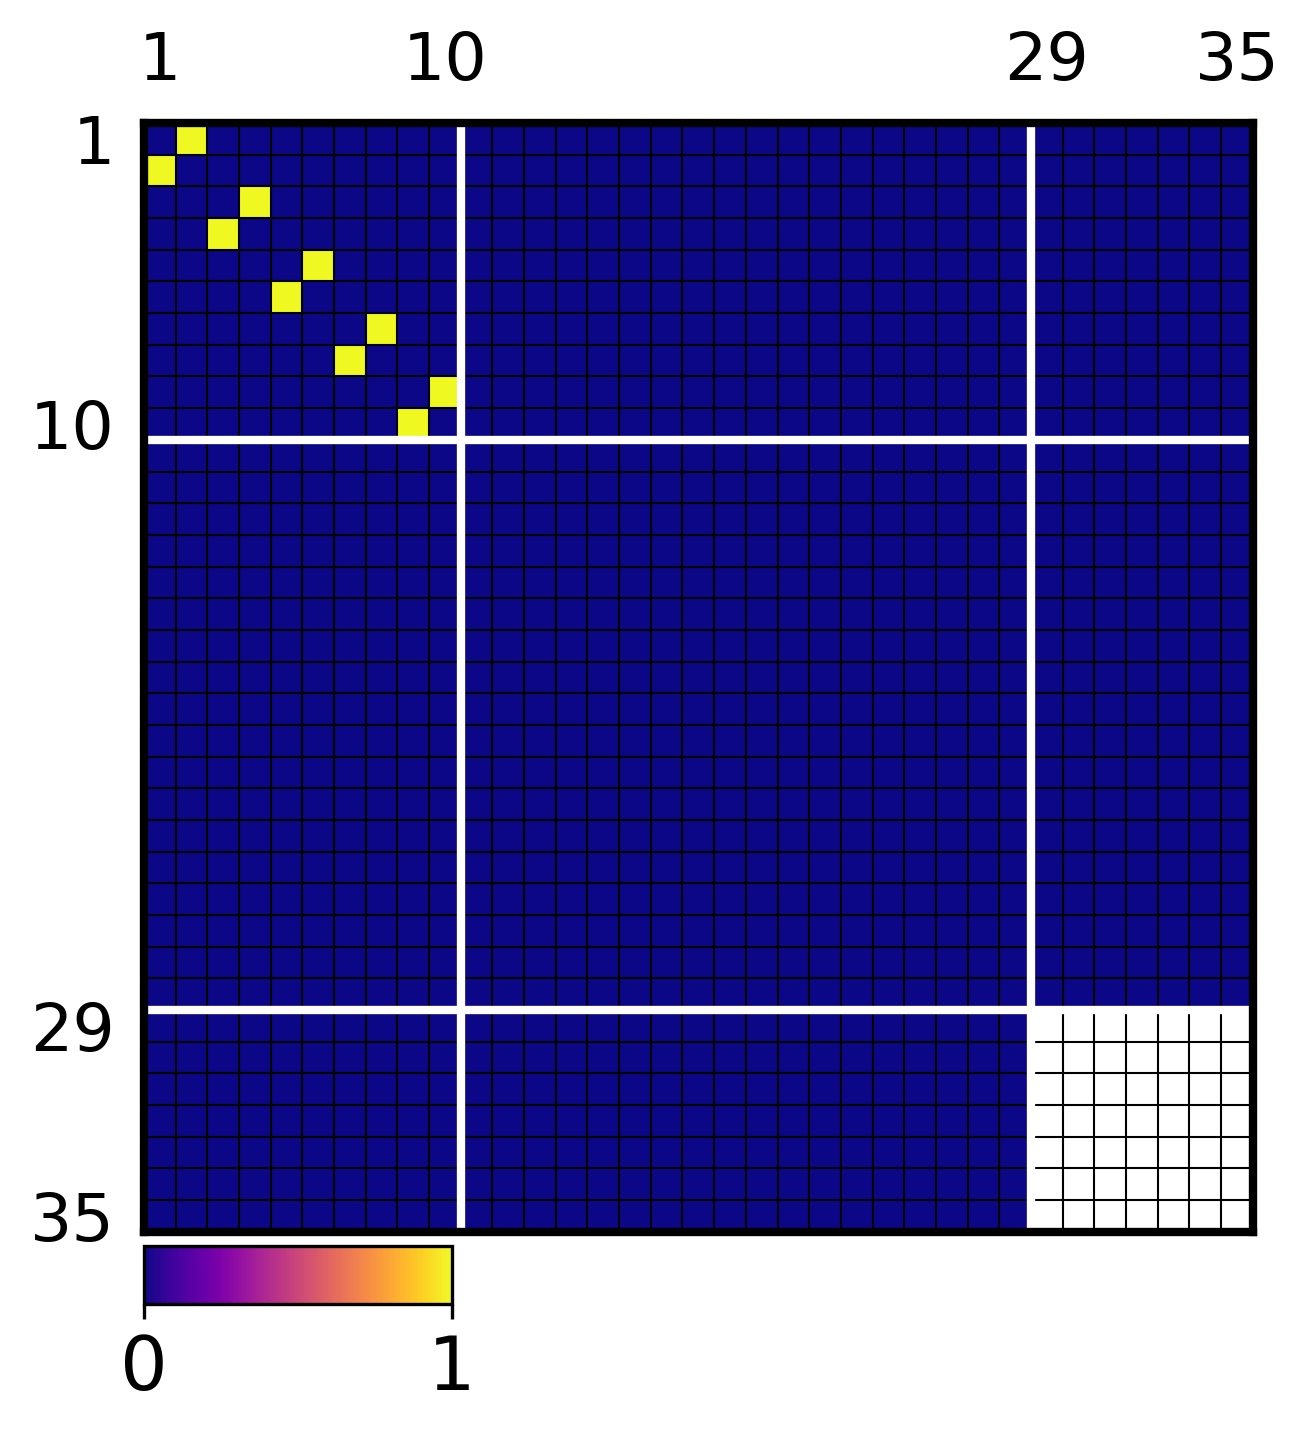

In [79]:
q,N=(5,35)
θtoyy=Pairwise(zeros(q,N), zeros(q,N,q,N))
θtoyy.J[:,1:10,:,1:10] = θpw.J;


fig, ax = subplots(dpi=300)
froJ_toy = get_fro(θtoyy.J)

froJ_toy[29:35, 29:35] .= NaN
im=im35(froJ_toy, ax, "plasma", false)

cax = fig.add_axes([ax.get_position().x0, ax.get_position().y0-0.05, 
    ax.get_position().x1*0.2, 0.04])

cbar = fig.colorbar(im, cax=cax, orientation="horizontal", ticks=[im.get_clim()...])
cbar.ax.set_xticklabels(map( x->@sprintf("%.1g",x), im.get_clim() ), fontsize=18 )   

# colorbar(im, cax=cax, orientation="horizontal", fontsize =14)

for axis in ["top","bottom","left","right"]
    ax.spines[axis].set_linewidth(2)
end

In [80]:
[ax.get_position().x0, ax.get_position().y1+0.05, 
    ax.get_position().x0+0.4, ax.get_position().y1+0.2 ]

4-element Vector{Float64}:
 0.22375
 0.93
 0.62375
 1.08

# Pull full model

In [82]:
M=500 #nsamples
Tsec=0.4

modls = [:Pairwise ]#, :RBM]#, :SRBM]
params_sets = Dict{Symbol,Any}(
    :Pairwise => Dict{Symbol, Any}(
        :reg_J => [(10f0^log10λ, 2) for log10λ ∈ -8:1],
        :reg_h => [(10f0^log10λ, 2) for log10λ ∈ 2:2],
        :epochs => 20_000,
        :showevery => 500,
        :progTol => 10^-6
    )
     ,
     :RBM => Dict{Symbol, Any}(
         :reg_W => [(10f0^log10λ, 2) for log10λ ∈ -8:-1],
         :reg_h => [(10f0^log10λ, 2) for log10λ ∈ 2:2],
         :P => [50],
         :epochs => 20_000,
         :showevery => 500,
         :progTol => 10^-6
     )
)

sampledir(args...) = datadir("toysector_q=5", 
    "nsamples=$(M)", args...)

z = BSON.load(
    sampledir( @sprintf("sector_temp=%.2f_samples.bson", Tsec) ) 
    )[:samples];
z = Float32.(z)
q,N,_=size(z)

(5, 35, 500)

In [83]:
fitsdir(args...) = sampledir("fitted_models", @sprintf("sector_temp=%.2f", 
        Tsec), args...)

fitsdir (generic function with 1 method)

In [84]:
nsamples_for_fpos = 10_000
θpw, θsec =  init_toy_model( Tsec )
q,N = (5,7)
all_states_buffer = (N*log(q)) < 21. ? AllStatesBuffer( q, N, θsec, θsec.FloatType ) : nothing
sec_energy_buffer = SectorEnergyBuffer( θsec , nsamples_for_fpos )
Htrue = H_toymodel( θpw, θsec )
q,N,_=size(z)

(5, 35, 500)

### put all models and fit trace info in a sweep dictionary

In [89]:
sweep_dicts = Dict{Symbol, Any}()
for mdl in modls
    sweep_dicts[mdl] = dict_list( params_sets[mdl] )
end
    

### for each model type (pairwise, rbm, sRBM)
for mdl in modls
    mdldir(args...) = fitsdir(string(mdl), args...)
    isdir(mdldir()) || mkpath(mdldir())
    swp_ds = sweep_dicts[mdl] #alias
    @printf "\n"
    @printf "%s model\n" string(mdl)
    for d in sweep_dicts[mdl]
        # name = savename(d)*"_2"
        name = savename(d)
        
        @printf "%s\n" name
	    if isfile(mdldir(name*".bson"))
            vecθ = BSON.load(mdldir(name*"_model.bson"))[:vecθ]
            P = haskey(d, :P) ? d[:P] : 0
            θ = initθ(mdl, q, N, P )
            zerosum!(θ)
            copyto!(θ, vecθ)
            d[:θ] = θ
            merge!(d, BSON.load(mdldir(name*".bson"))[:d])
        end
    end
end


Pairwise model
L2_regh=1e2.0_regJ=1e-8.0
L2_regh=1e2.0_regJ=1e-7.0
L2_regh=1e2.0_regJ=1e-6.0
L2_regh=1e2.0_regJ=1e-5.0
L2_regh=1e2.0_regJ=1e-4.0
L2_regh=1e2.0_regJ=1e-3.0
L2_regh=1e2.0_regJ=1e-2.0
L2_regh=1e2.0_regJ=1e-1.0
L2_regh=1e2.0_regJ=1e0.0
L2_regh=1e2.0_regJ=1e1.0


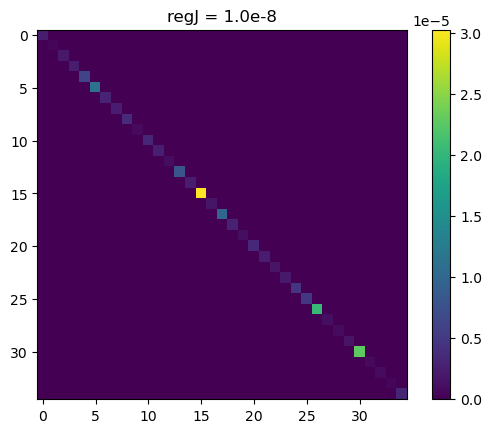

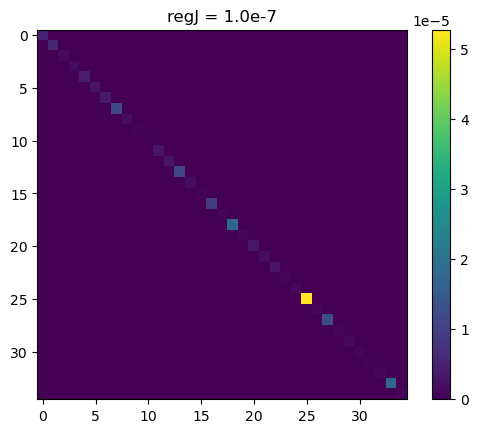

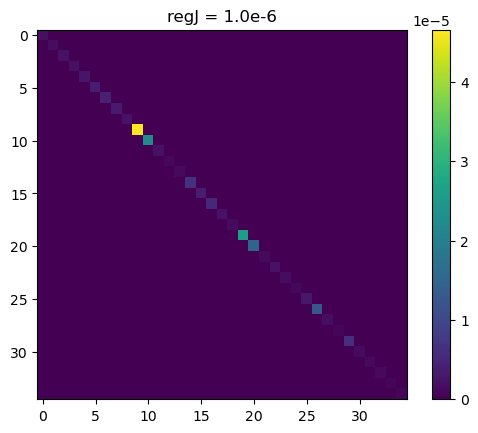

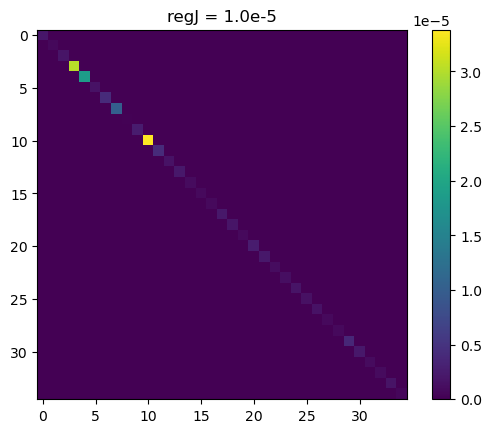

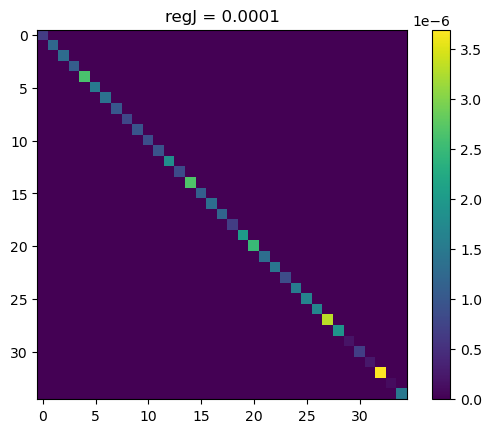

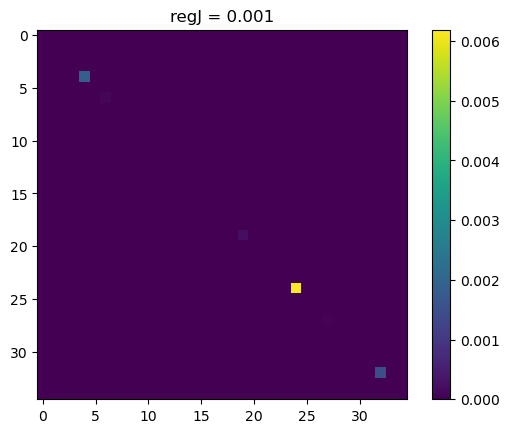

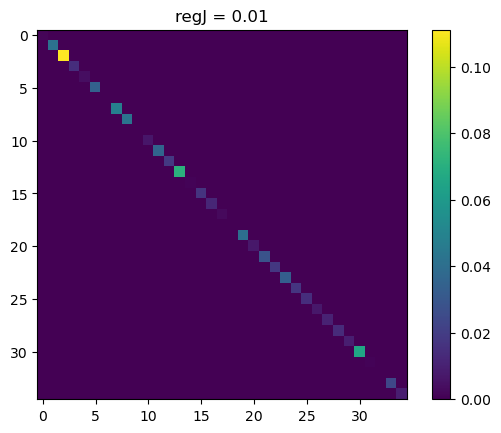

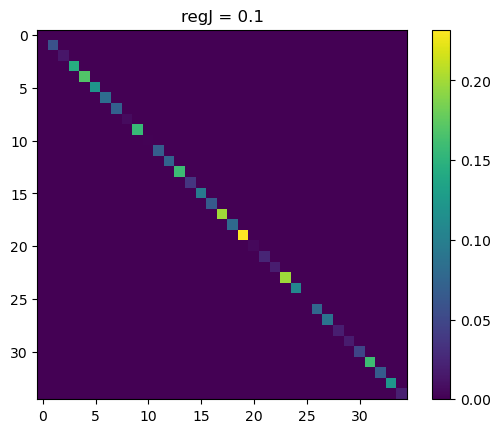

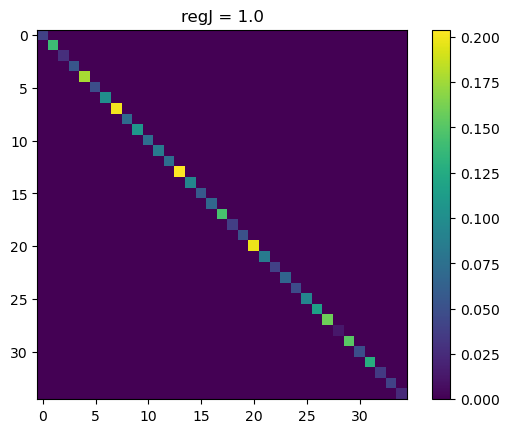

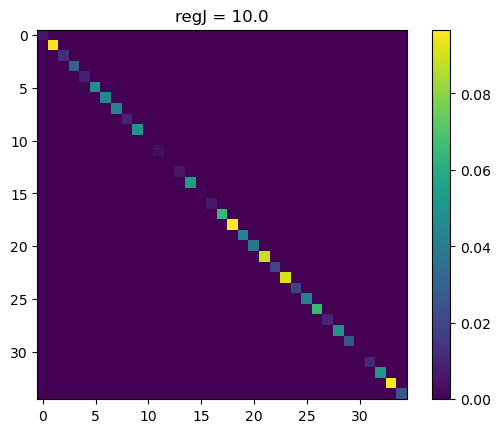

In [90]:
for d in sweep_dicts[:Pairwise]
    fig, ax = subplots()
    imshow( diagm(get_fro(d[:θ].h)))
    title("regJ = $(d[:reg_J][1])")
    colorbar()
end

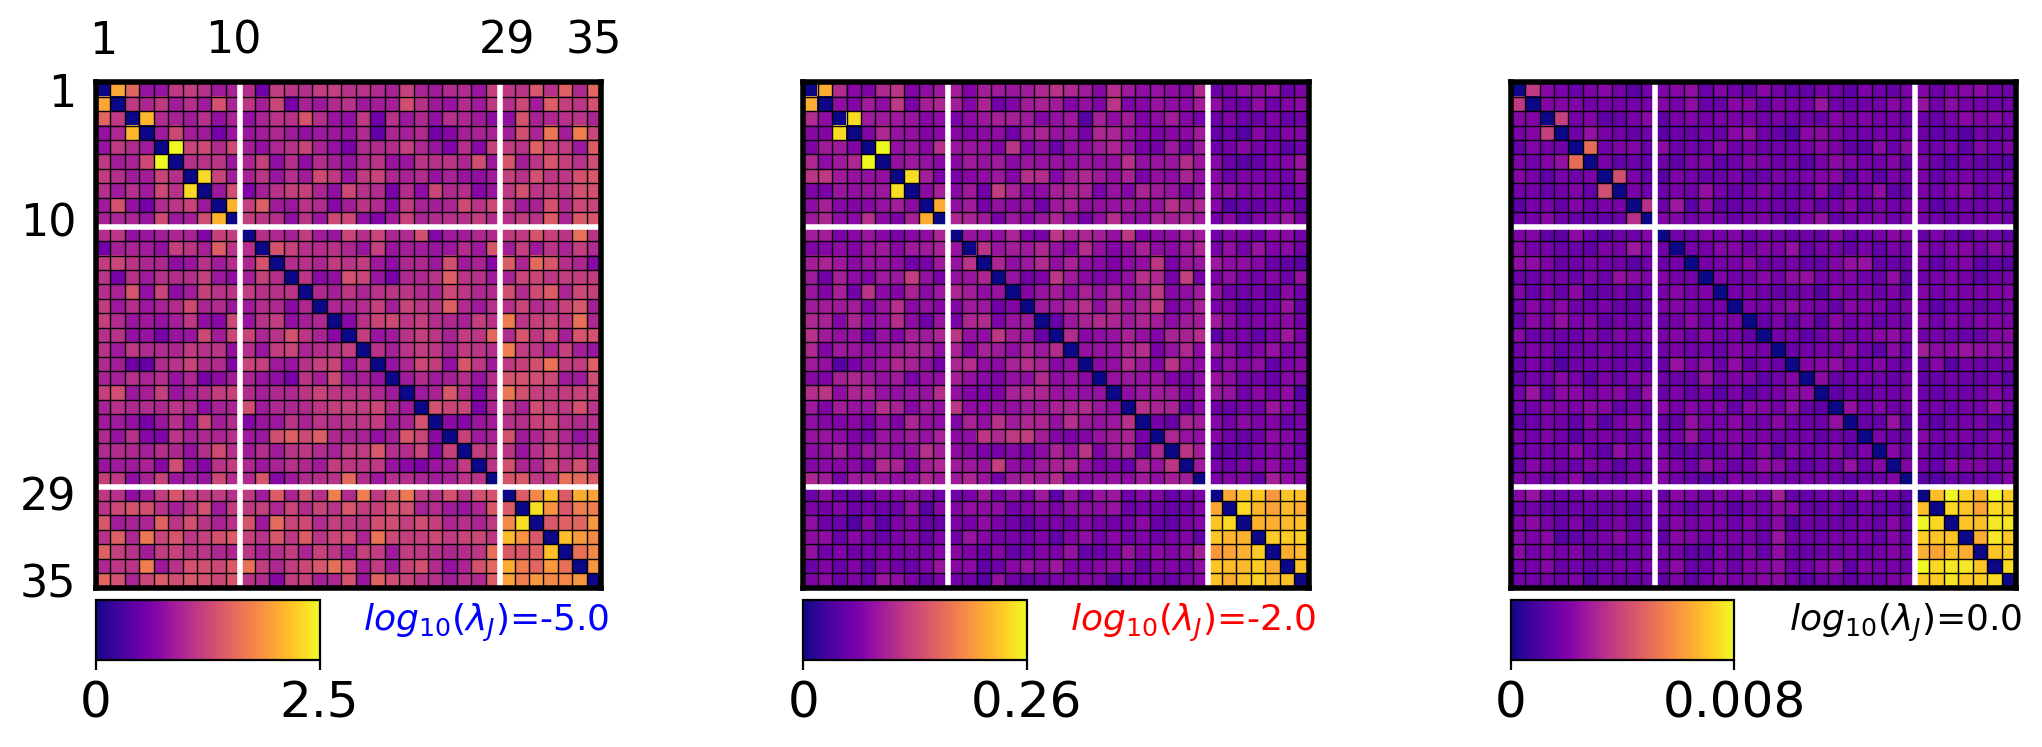

In [91]:
fig, ax = subplots(1,3, dpi=200, figsize=(12,12))
ax=ax[:]
permute!(ax, [1,2,3])

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

i=1
for (d,col) in zip(sweep_dicts[:Pairwise][[4,7,9]], ["blue", "red", "k"])
    im = i ==1 ? im35( get_fro(d[:θ].J),ax[i], "plasma", false) : im35( get_fro(d[:θ].J),
        ax[i], "plasma", true)
    
    # ax[i].set_title("regJ = $(d[:reg_J][1])")
    cax = fig.add_axes([ax[i].get_position().x0, ax[i].get_position().y0-0.03, 
    ax[1].get_position().x1*0.3, 0.025])
    posx, posy = i != 3 ? (18, 37.5) : (18.8, 37.5) 
    # col = i == 2 ? "red" : "k"
    ax[i].text(posx,posy, L"log_{10}(λ_J)"*"=$(log10(d[:reg_J][1]))", fontsize=13, c=col) 
        

    # cbar = colorbar(im, cax=cax, )
    cbar = fig.colorbar(im, cax=cax, orientation="horizontal", ticks=[im.get_clim()...])
    i ==3 ? cbar.ax.set_xticklabels(map( x->@sprintf("%.1g",x), im.get_clim() ), fontsize=18 )  : 
        cbar.ax.set_xticklabels(map( x->@sprintf("%.2g",x), im.get_clim() ), fontsize=18 ) 
    # cbar.ax.set_xticklabels(fontsize=15)
    for axis in ["top","bottom","left","right"]
        ax[i].spines[axis].set_linewidth(2)
    end
    
    # colorbar(im, orientation="horizontal")
    i+=1
    
end



03.5

(nothing, nothing)

### pull regs and losses from hyperparameter sweep dicts

In [92]:
losses_pw   = pull_from_sweep(sweep_dicts[:Pairwise], 
    [:reg_h, :reg_J, :mean𝕍] 
    )
best_idx_pw = findmin(losses_pw[:,end])[2]
best_pw_reg_h, best_pw_reg_J, _ = losses_pw[best_idx_pw, :]

to_pull_from_sweep = [:reg_J, :mean𝕍, :std𝕍, :inloss ]

( push!( to_pull_from_sweep, :false_pos_rate ) )
( push!( to_pull_from_sweep, :fit_entropy  ) )

@show to_pull_from_sweep

losses_pw   = pull_from_sweep(sweep_dicts[:Pairwise], 
    to_pull_from_sweep ;
    reg_h = best_pw_reg_h
    )

to_pull_from_sweep = [:reg_J, :mean𝕍, :std𝕍, :inloss, :false_pos_rate, :fit_entropy]


10×6 Matrix{Any}:
 (1.0f-8, 2)  1.64247   0.0415588    0.285363  0.4809  17.5711
 (1.0f-7, 2)  1.62335   0.0345133    0.299879  0.4015  25.1972
 (1.0f-6, 2)  1.61322   0.0392778    0.293411  0.4433  21.9956
 (1.0f-5, 2)  1.49302   0.0422242    0.31598   0.3419  33.6864
 (0.0001, 2)  1.27591   0.0331285    0.364824  0.3863  45.6366
 (0.001, 2)   1.03955   0.0172341    0.480077  0.5171  52.6398
 (0.01, 2)    0.924827  0.008078     0.715555  0.6722  55.794
 (0.1, 2)     0.966993  0.00295782   0.929074  0.7992  56.2809
 (1.0, 2)     0.996825  0.000876705  0.992161  0.8337  56.3022
 (10.0, 2)    1.00076   0.000529076  0.999141  0.8339  56.3266

### now create array with temperatures, fpos, and different reg strengths
-should be able to hold T or reg fixed and get fpos vs ent
-also need to make heatmaps as well

##### heat map arrays

In [99]:
nregs = 10
nsampTs = 10

θpw, θsec =  init_toy_model( Tsec )
sec_energy_buffer = SectorEnergyBuffer(θsec, 6_000)

hmap_fpos = zeros(nregs,nsampTs)
hmap_ent = zeros(nregs,nsampTs)
loglambdas = zeros(nregs)
Tsamps = 0.1:0.1:1

allsamps = Matrix{Any}(nothing, nregs, nsampTs)

# samps[k] = BSON.load( fitsdir(savename(d)*"_samples_T=$(Tsamp).bson"))[:results]

for (i,d) in enumerate(sweep_dicts[:Pairwise])
    loglambdas[i] = round(log10(d[:reg_J][1]))
    
    for j in 1:nsampTs
        # get samps for model at given temp
        name = savename(d)
        samplestring="_samples_T=$(Tsamps[j])_2.bson"
        
        allsamps[i,j] = BSON.load( fitsdir("Pairwise",
                name*samplestring))[:results]
        
        # comment out below after I fix the ais code
        # logZ₀ = sum( log.( sum( exp.( d[:θ].h ), dims=1 )))
        # logZ₀T = sum( log.( sum( exp.( d[:θ].h./Tsamps[j] ), dims=1 )))
        # get entropy estimate
        hmap_ent[i,j] = allsamps[i,j][:fit_entropy][:entropy] #- logZ₀ + logZ₀T
        
        # get false positive rate
        z = allsamps[i,j][:z_from_fit]
        E_under_gt = sectorenergy(z[:,29:35,:], θsec, sec_energy_buffer)
        n_fpos = E_under_gt .== Inf32
        hmap_fpos[i,j] = sum(n_fpos)/length(n_fpos)
    end
end


# for each lambda (row) (low to high)
  # sweep through temps (columns) low to high and populate each heat map

In [100]:
allsamps[1,1][:fit_entropy]

Dict{Symbol, Any} with 3 entries:
  :logZ    => 994.93
  :entropy => 4.76251
  :meanE   => -990.168

In [101]:
hmap_ent 

10×10 Matrix{Float64}:
  4.76251   2.99094   5.17404  …  11.5312  14.2554  17.2571  19.8196
  3.82361   4.4429    5.53503     15.3796  19.2803  23.1198  26.7642
  4.49182   4.02585   5.66122     13.33    17.205   20.4136  23.8606
  4.0694    5.36096   7.31755     23.4252  27.6793  31.0933  34.0335
  4.80325   9.04599  15.7854      38.5433  41.6291  44.0483  45.8334
  8.9917   23.203    33.1217   …  47.441   48.7777  50.3479  51.3676
 25.7363   37.717    45.0751      54.5612  54.4815  54.848   55.452
 42.9864   52.3169   54.6992      55.9525  56.1946  56.1431  56.2523
 51.4402   54.6769   55.857       56.2352  56.2497  56.2835  56.2875
 55.4458   56.2293   56.3406      56.3381  56.3305  56.3246  56.3204

In [35]:
Tsamps

0.1:0.1:1.0

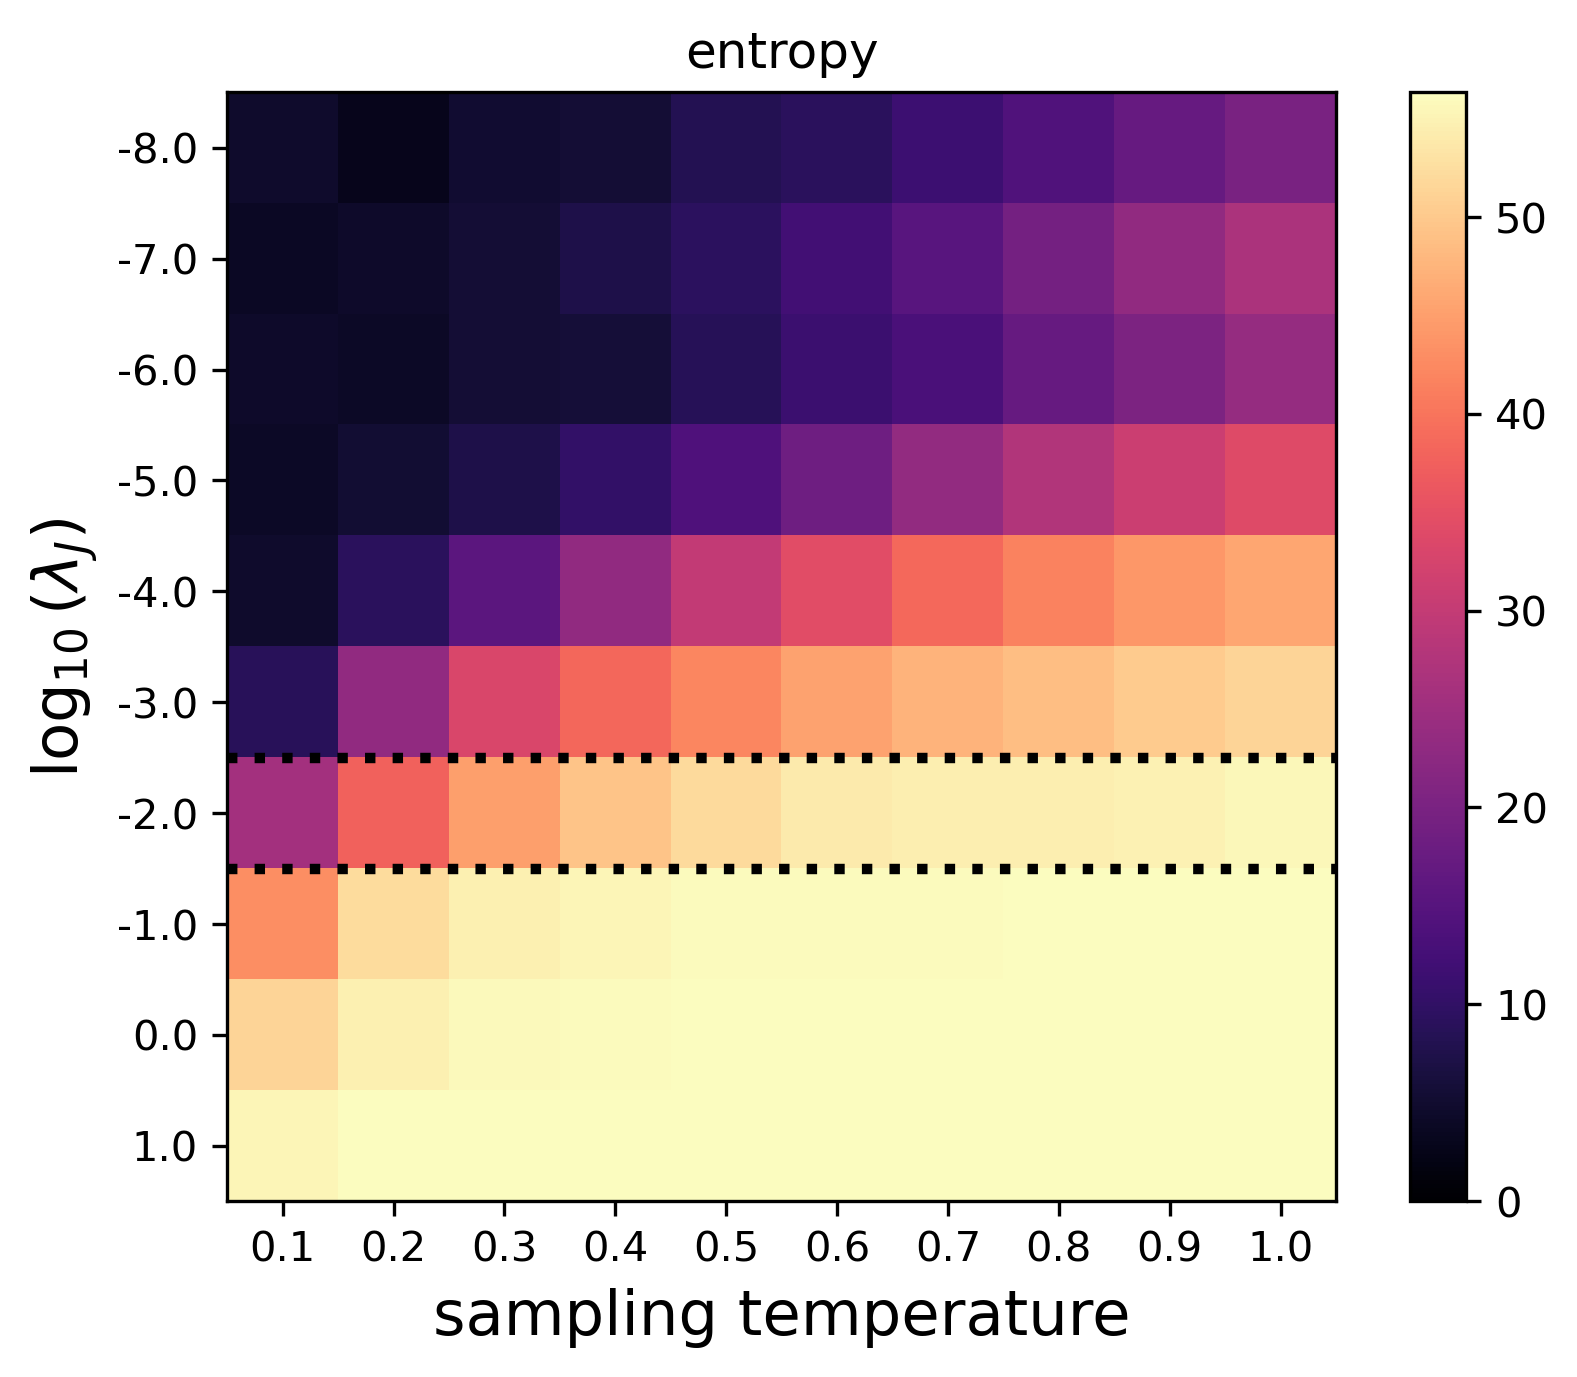

PyObject <matplotlib.collections.LineCollection object at 0x15eb6f2e0>

In [103]:
fig, ax = subplots(dpi=300)

im=imshow(hmap_ent, cmap="magma")
clim(0,35*log(5))
colorbar()
ax=gca()
ax.set_yticks(collect(0:9))
ax.set_yticklabels(loglambdas)
ax.set_xticks(collect(0:9))
ax.set_xticklabels(collect(Tsamps))
ax.set_title("entropy")
ax.set_ylabel(L"\log_{10}(\lambda_J)", fontsize=15)
ax.set_xlabel("sampling temperature", fontsize=15)




ax.hlines(6.5,-0.5,9.5, color="k", linestyle="dotted", linewidth=2.5)
ax.hlines(5.5,-0.5,9.5, color="k", linestyle="dotted", linewidth=2.5)

In [96]:
hmap_fpos

10×10 Matrix{Float64}:
 0.399667     0.369833   0.391333   …  0.405167  0.4055    0.4015
 0.434333     0.421      0.41          0.425     0.4445    0.454167
 0.374167     0.359      0.363833      0.384833  0.386333  0.385667
 0.3          0.311333   0.332667      0.363833  0.382333  0.340833
 0.0725       0.113333   0.079         0.2335    0.275167  0.294333
 0.000666667  0.0175     0.0266667  …  0.292333  0.281833  0.381333
 0.00183333   0.0188333  0.0776667     0.4545    0.510833  0.537167
 0.131333     0.392      0.573667      0.737667  0.762333  0.770667
 0.779333     0.811      0.817167      0.8295    0.8275    0.833833
 0.836        0.823667   0.852         0.831667  0.8295    0.828667

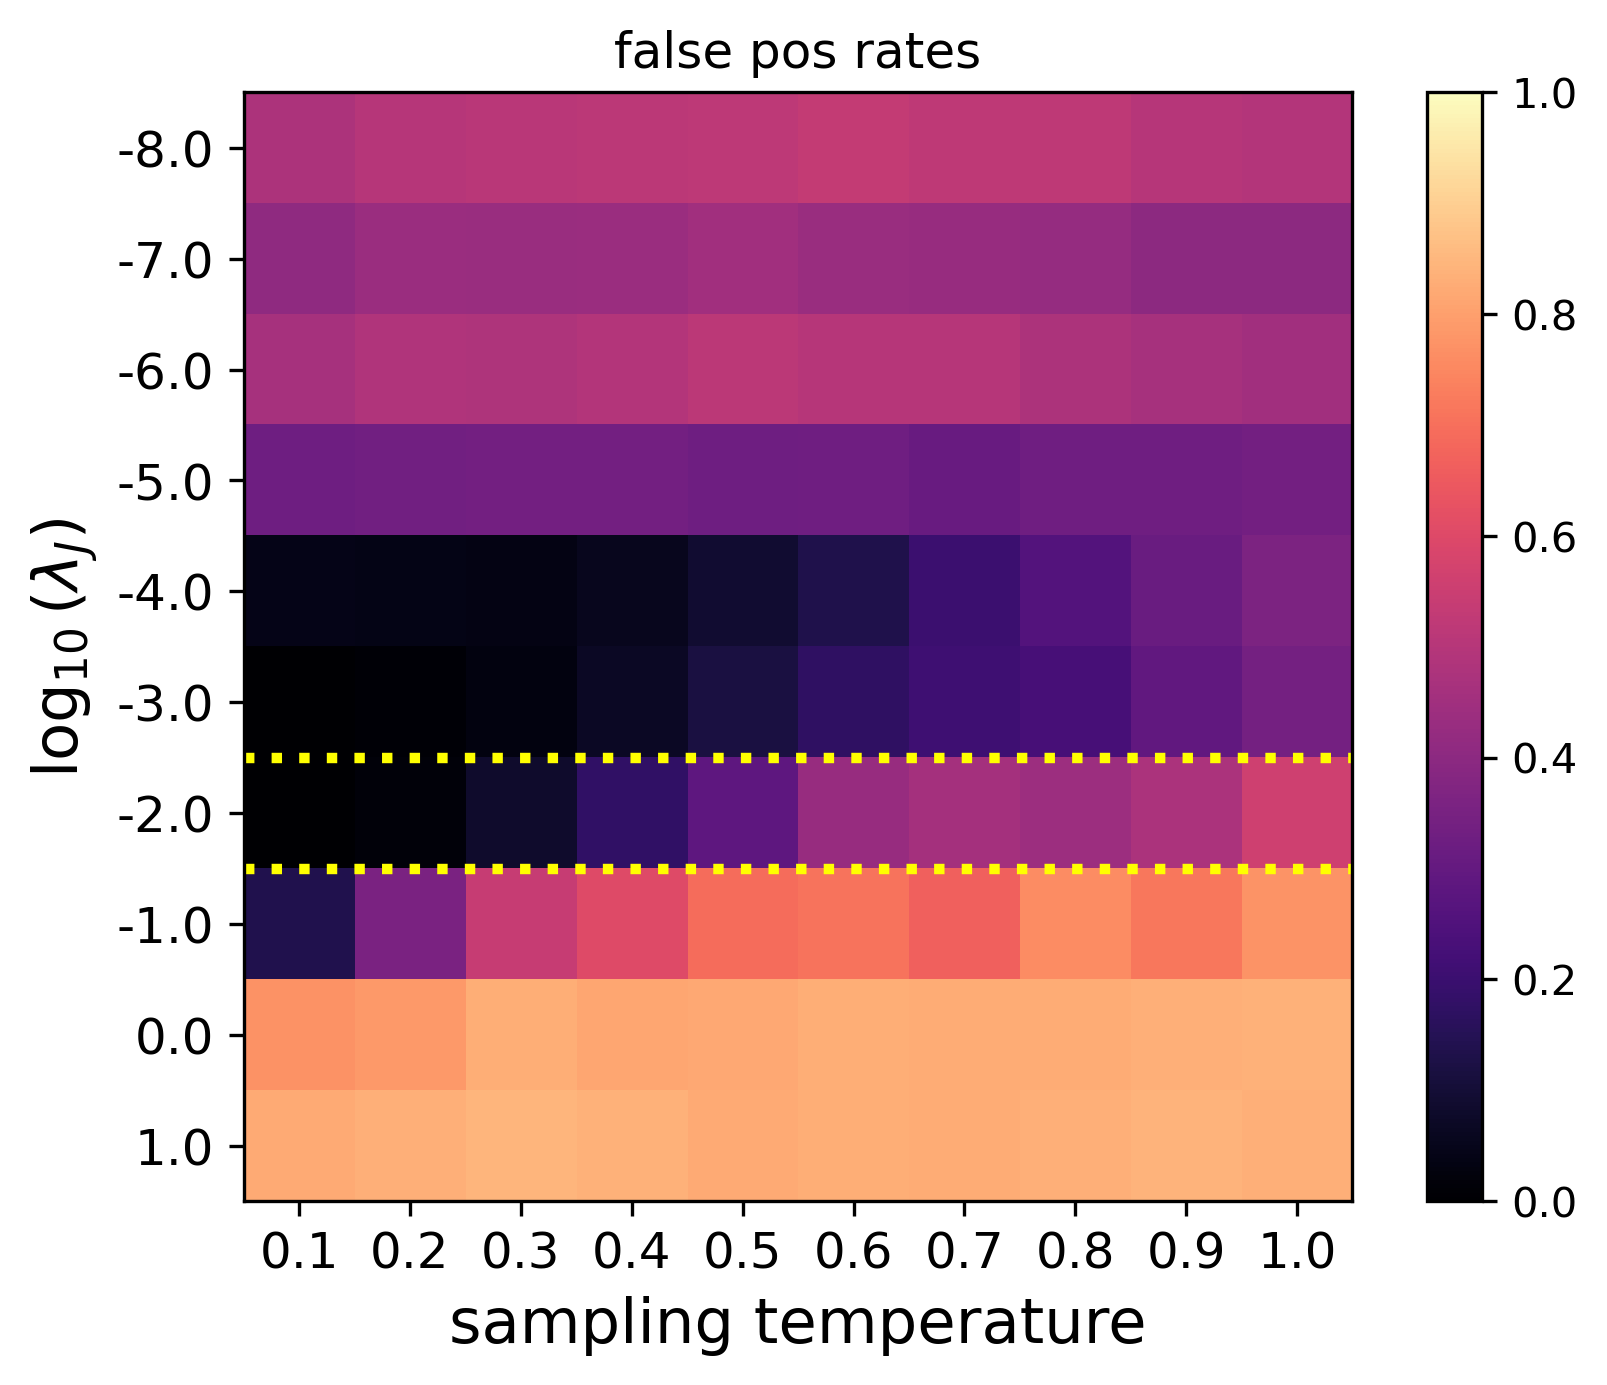

PyObject <matplotlib.collections.LineCollection object at 0x15eb8c490>

In [104]:
fig, ax = subplots(dpi=300)


imshow(hmap_fpos, cmap="magma")
colorbar()
clim(0,1)
ax=gca()
ax.set_ylabel(L"\log_{10}(\lambda_J)", fontsize=15)
ax.set_xlabel("sampling temperature", fontsize=15)
ax.set_yticks(collect(0:9))
ax.set_yticklabels(loglambdas, fontsize=12)
ax.set_xticks(collect(0:9))
ax.set_xticklabels(collect(Tsamps), fontsize=12)

ax.set_title("false pos rates")

ax.hlines(6.5,-0.5,9.5, color="yellow", linestyle="dotted",linewidth=2.5)
ax.hlines(5.5,-0.5,9.5, color="yellow", linestyle="dotted",linewidth=2.5)

##### check the traces of the AIS

In [15]:
allsamps[1,2][:fit_entropy]

Dict{Symbol, Any} with 3 entries:
  :logZ    => 500.255
  :entropy => 2.99094
  :meanE   => -497.264

In [16]:
allsamps[1,2][:ais_trace]

Dict{Symbol, Any} with 6 entries:
  :stdEᵦ₍ᵢ₋₁₎        => Float32[0.000100464, 0.000100711, 0.000100344, 0.000100…
  :meanEᵦ₍ᵢ₋₁₎       => Float32[6.16322f-5, 6.18632f-5, 6.15926f-5, 6.18543f-5,…
  :accrate           => Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.…
  :sample_steps_used => Float32[112.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0…
  :Ƶ                 => Float32[0.906102, 0.913518, 0.919805, 0.926299, 0.93503…
  :time              => Float32[0.00115395, 0.00208092, 0.00298691, 0.00387692,…

In [17]:
kk = 1 #index for which slice of temps to look at

1

In [18]:
@show Tsamps[kk]
for (i,d) in enumerate(sweep_dicts[:Pairwise])
    loglambdas[i] = round(log10(d[:reg_J][1]))
    
    ggg=allsamps[i,kk][:fit_entropy]

    @show ggg
        
end

Tsamps[kk] = 0.1
ggg = Dict{Symbol, Any}(:logZ => 994.93036f0, :entropy => 4.762512f0, :meanE => -990.16785f0)
ggg = Dict{Symbol, Any}(:logZ => 791.29126f0, :entropy => 3.8236084f0, :meanE => -787.46765f0)
ggg = Dict{Symbol, Any}(:logZ => 883.85126f0, :entropy => 4.4918213f0, :meanE => -879.35944f0)
ggg = Dict{Symbol, Any}(:logZ => 638.20294f0, :entropy => 4.069397f0, :meanE => -634.13354f0)
ggg = Dict{Symbol, Any}(:logZ => 385.27713f0, :entropy => 4.803253f0, :meanE => -380.47388f0)
ggg = Dict{Symbol, Any}(:logZ => 233.2388f0, :entropy => 8.991699f0, :meanE => -224.2471f0)
ggg = Dict{Symbol, Any}(:logZ => 128.72816f0, :entropy => 25.736267f0, :meanE => -102.9919f0)
ggg = Dict{Symbol, Any}(:logZ => 61.82328f0, :entropy => 42.986397f0, :meanE => -18.836884f0)
ggg = Dict{Symbol, Any}(:logZ => 56.142754f0, :entropy => 51.440193f0, :meanE => -4.7025614f0)
ggg = Dict{Symbol, Any}(:logZ => 56.26046f0, :entropy => 55.445793f0, :meanE => -0.81466585f0)


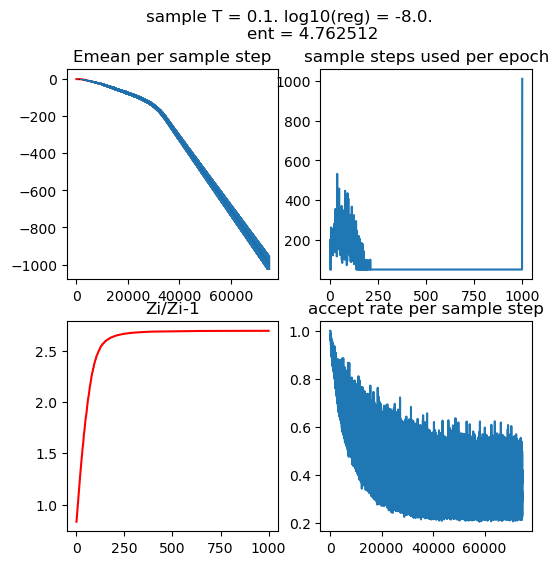

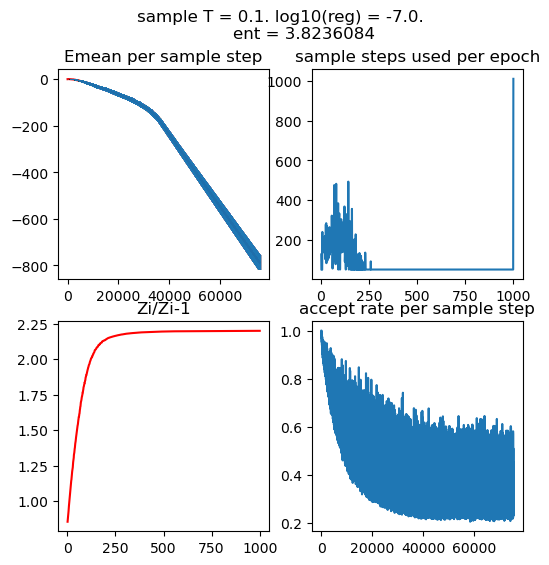

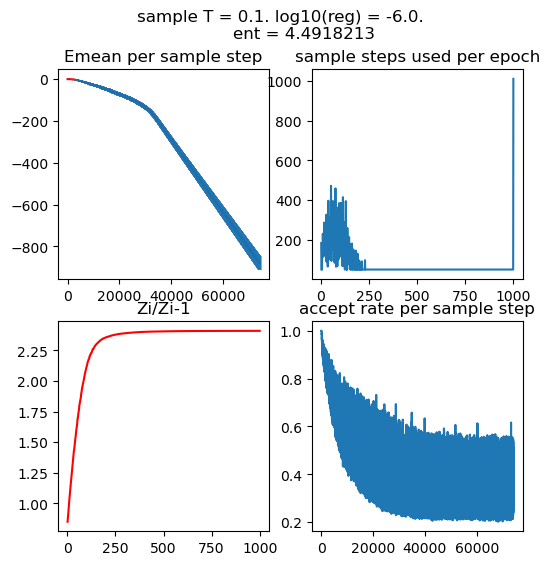

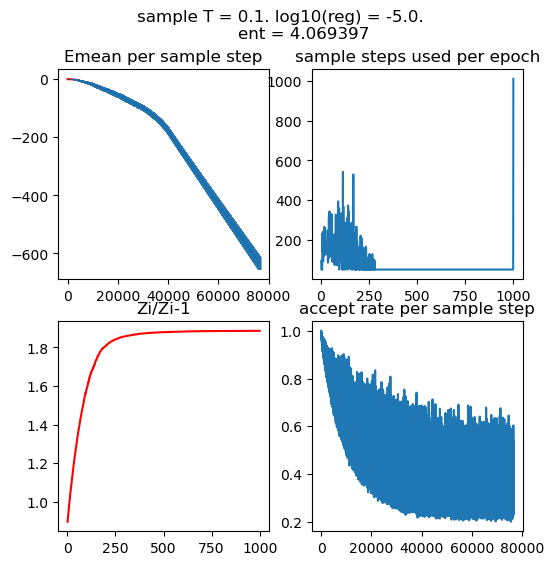

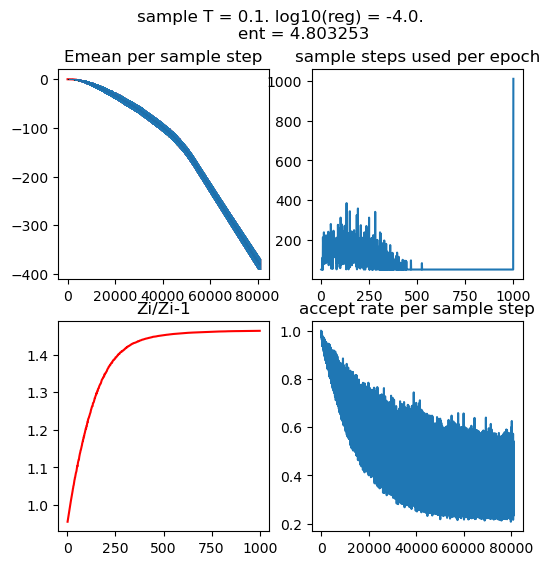

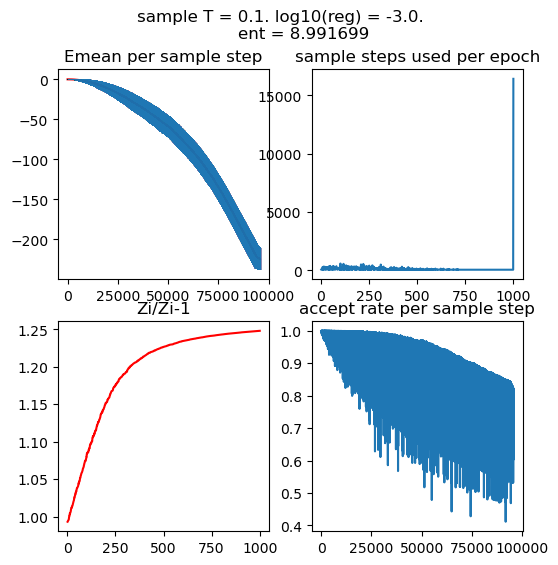

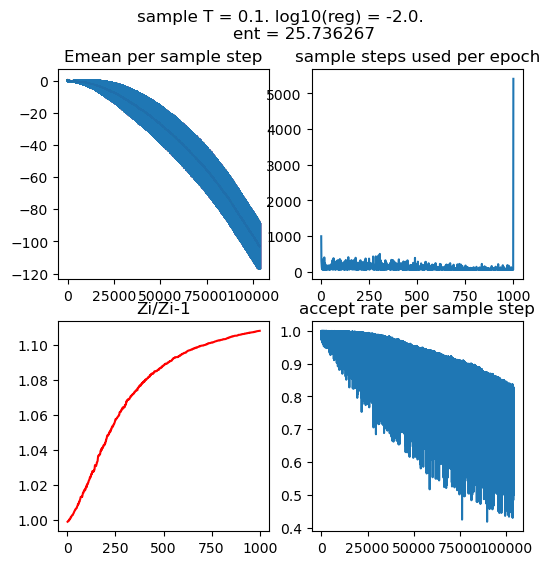

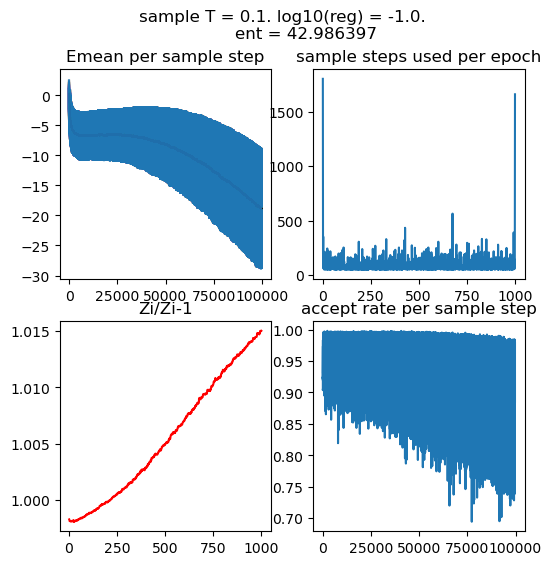

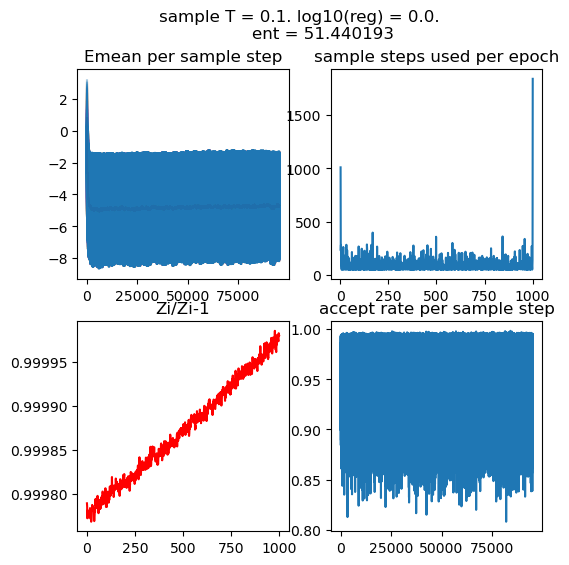

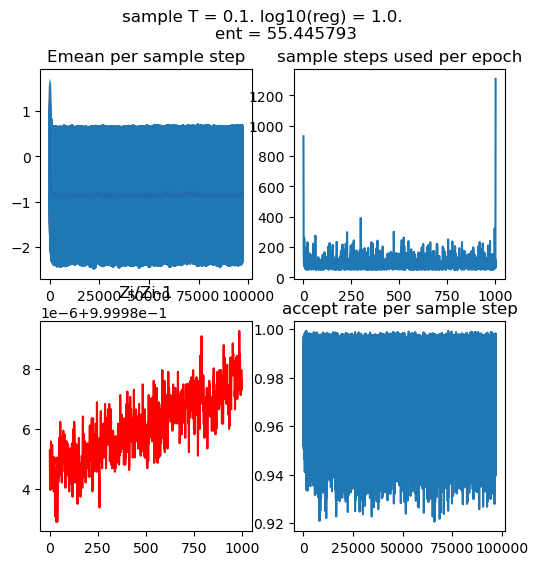

In [339]:
for (i,d) in enumerate(sweep_dicts[:Pairwise])
    loglambdas[i] = round(log10(d[:reg_J][1]))
    
    trace=allsamps[i,kk][:ais_trace]

    fig, ax = subplots(2,2, figsize=(6,6))
    ax= ax[:]

    ax[1].plot(collect(1:length(trace[:meanEᵦ₍ᵢ₋₁₎])), 
        trace[:meanEᵦ₍ᵢ₋₁₎], c="r")
    ax[1].errorbar(collect(1:length(trace[:meanEᵦ₍ᵢ₋₁₎])), 
        trace[:meanEᵦ₍ᵢ₋₁₎], yerr=trace[:stdEᵦ₍ᵢ₋₁₎], alpha=0.1)
    ax[1].set_title("Emean per sample step")

    ax[2].plot(collect(1:length(trace[:Ƶ])), 
        trace[:Ƶ], c="r")
    ax[2].set_title("Zi/Zi-1")

    ax[3].plot(collect(1:length(trace[:sample_steps_used])), trace[:sample_steps_used])
    ax[3].set_title("sample steps used per epoch")

    ax[4].plot(collect(1:length(trace[:accrate])), trace[:accrate])
    ax[4].set_title("accept rate per sample step")
    
    suptitle("sample T = $(Tsamps[kk]). log10(reg) = $(loglambdas[i]). 
        ent = $(allsamps[i,kk][:fit_entropy][:entropy])")
        
end
    

### make plots of f_pos vs entropy for diffent fixed T or regJ

In [84]:
ll

10-element Vector{Float64}:
 -8.0
 -7.0
 -6.0
 -5.0
 -4.0
 -3.0
 -2.0
 -1.0
  0.0
  1.0

10-element Vector{Float64}:
 0.0
 0.1111111111111111
 0.2222222222222222
 0.3333333333333333
 0.4444444444444444
 0.5555555555555556
 0.6666666666666666
 0.7777777777777778
 0.8888888888888888
 1.0

In [74]:
idxxs

LoadError: UndefVarError: idxxs not defined

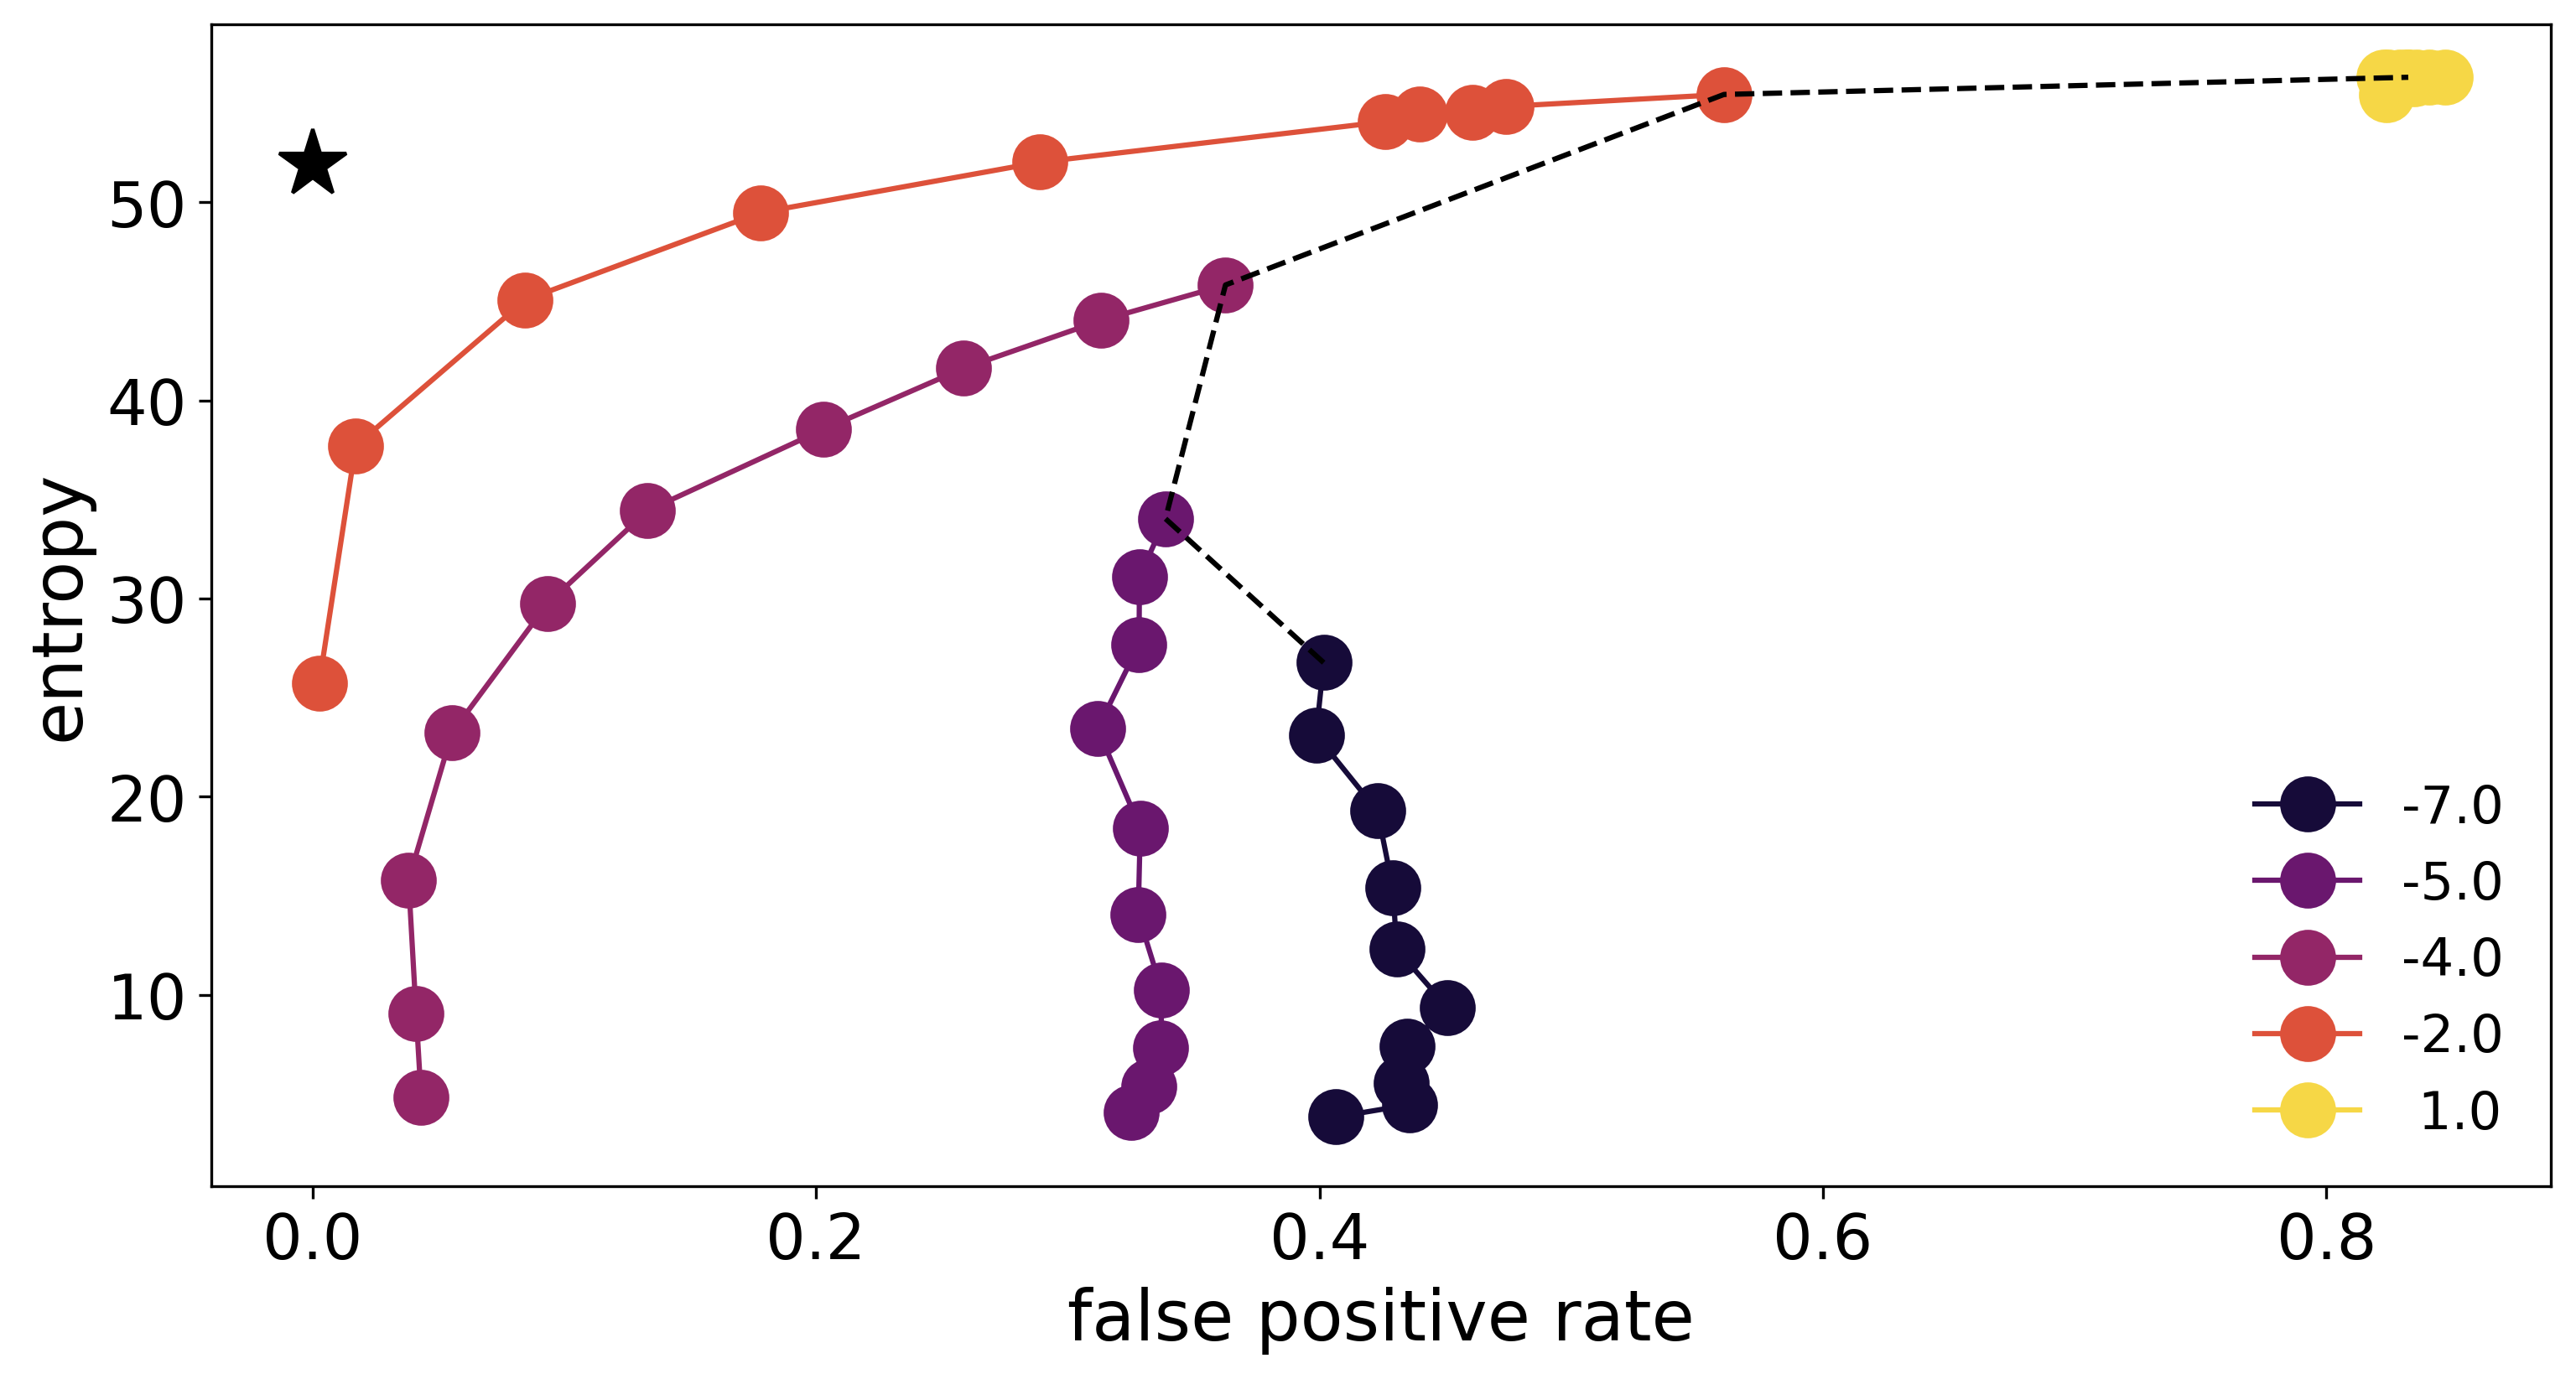

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x15f867d00>

In [107]:
# fix a given lambda change T
fig, ax = subplots(figsize = (12,6), dpi=300)
startT_idx=1
lastT_idx = 10
# ll =loglambdas
iddxxs = [2, 4,5,7,10]
ll = [ -8, -7.0, -6, -5.0, -4.0, -3, -2.0, -1.0, 0.0, 1]
zorders = [2,3,4,5,6,7,8,1,9,10]
lpl = 1

c = ColorMap("inferno")(collect(range(0,0.9,10)))
for i in iddxxs
    logλ = ll[i]
    row_idx = findall(loglambdas .== logλ)
    row_idx = row_idx[1]
    ccc =  logλ == -2 ? "red" : c[i,:]
    ccc =c[i,:]
    if logλ <= lpl 
        # c =  logλ == 2 ? "red" : c[i,:]
        msize = logλ == -2 ? 15 : 15
        label = logλ > -1 ? " $logλ" : "$logλ"
        ax.plot( hmap_fpos[row_idx,startT_idx:lastT_idx], hmap_ent[row_idx,startT_idx:lastT_idx], 
        "-", label=label, c=ccc, markersize=msize, marker="o",zorder=zorders[i])
    else 
        ax.plot( hmap_fpos[row_idx,lastT_idx:lastT_idx], hmap_ent[row_idx,lastT_idx:lastT_idx], 
        "-", label=label, c=ccc, markersize=10, marker="o", zorder=zorders[i])
    end
end
ax.legend(loc="lower right", fontsize=15, frameon=false)
ax.set_ylabel("entropy", fontsize=20)
ax.set_xlabel("false positive rate", fontsize=20)
ax.set_xlim(-0.040075000000000006, 0.8892416666666666)
ax.set_ylim(0.32441342507015714, 58.98683932302265)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)

ax.plot( hmap_fpos[iddxxs,10], hmap_ent[iddxxs,10], 
        "--", label="T=1", c="k", alpha=1, zorder=20, markersize=5)

ax.plot(0, H_toymodel(init_toy_model(Tsec)...)[:Htotal], "k*", markersize=20)
# ax.text(0.01, 1.5+H_toymodel(init_toy_model(Tsec)...)[:Htotal], "ground truth", )
# ax.set_title("varying T for fixed lambdas")

In [499]:
ax.get_ylim()

(0.32441342507015714, 58.98683932302265)

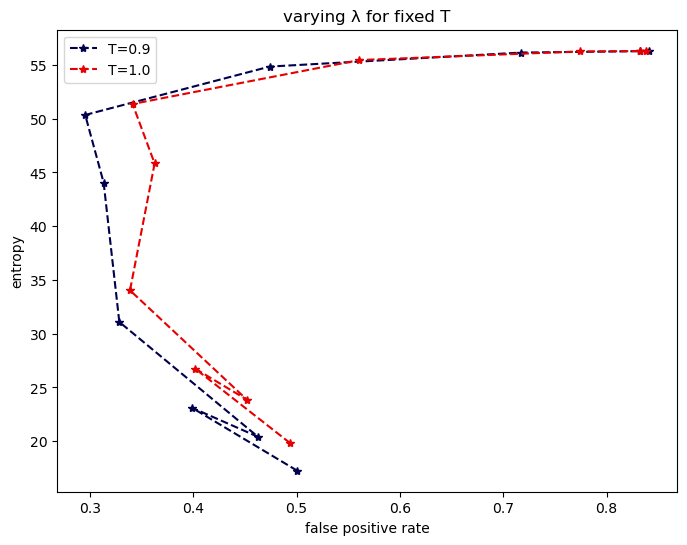

PyObject Text(0.5, 1.0, 'varying λ for fixed T')

In [445]:
# fix a given T change lambda
fig, ax = subplots(figsize = (8,6))
startT_idx=9

ts = Tsamps[startT_idx:end]
# ts = 

c = ColorMap("seismic")(collect(range(0,0.8,length(ts))))
for (i,T) in enumerate(ts)
    col_idx = findall(Tsamps .== T)
    col_idx = col_idx[1]
    ax.plot( hmap_fpos[:,col_idx], hmap_ent[:,col_idx], 
        "--*", label="T=$T", c=c[i,:])
end
ax.legend()
ax.set_ylabel("entropy")
ax.set_xlabel("false positive rate")

ax.set_title("varying λ for fixed T")

### look at energy histograms for differnt models as function of T

In [28]:
eltype(Float32[])(1)

1.0f0

In [41]:
z_synth = BSON.load(
    sampledir( @sprintf("sector_temp=%.2f_samples.bson", Tsec) ) 
    )[:samples];
z_synth = Float32.(z_synth);

In [109]:
Enatural_permodel = Vector{Any}(nothing, length(loglambdas))
for k in 1:length(loglambdas)
    @show sweep_dicts[:Pairwise][k][:reg_J]
    Enatural_permodel[k] = energy(z_synth, sweep_dicts[:Pairwise][k][:θ] )
end

((sweep_dicts[:Pairwise])[k])[:reg_J] = (1.0f-8, 2)
((sweep_dicts[:Pairwise])[k])[:reg_J] = (1.0f-7, 2)
((sweep_dicts[:Pairwise])[k])[:reg_J] = (1.0f-6, 2)
((sweep_dicts[:Pairwise])[k])[:reg_J] = (1.0f-5, 2)
((sweep_dicts[:Pairwise])[k])[:reg_J] = (0.0001f0, 2)
((sweep_dicts[:Pairwise])[k])[:reg_J] = (0.001f0, 2)
((sweep_dicts[:Pairwise])[k])[:reg_J] = (0.01f0, 2)
((sweep_dicts[:Pairwise])[k])[:reg_J] = (0.1f0, 2)
((sweep_dicts[:Pairwise])[k])[:reg_J] = (1.0f0, 2)
((sweep_dicts[:Pairwise])[k])[:reg_J] = (10.0f0, 2)


In [110]:
Tsamps
# loglambdas

10-element Vector{Float64}:
 0.1
 0.2
 0.3
 0.4
 0.5
 0.6
 0.7
 0.8
 0.9
 1.0

In [111]:
all_Esamps = Matrix{Any}(nothing, nregs, nsampTs)

for i in 1:length(loglambdas)
    @show sweep_dicts[:Pairwise][i][:reg_J]
    θ = sweep_dicts[:Pairwise][i][:θ] 
    for j in 1:length(Tsamps)
        # @show size(allsamps[i,j][:z_from_fit])
        all_Esamps[i,j] = energy( allsamps[i,j][:z_from_fit] , θ )
    end
end

((sweep_dicts[:Pairwise])[i])[:reg_J] = (1.0f-8, 2)
((sweep_dicts[:Pairwise])[i])[:reg_J] = (1.0f-7, 2)
((sweep_dicts[:Pairwise])[i])[:reg_J] = (1.0f-6, 2)
((sweep_dicts[:Pairwise])[i])[:reg_J] = (1.0f-5, 2)
((sweep_dicts[:Pairwise])[i])[:reg_J] = (0.0001f0, 2)
((sweep_dicts[:Pairwise])[i])[:reg_J] = (0.001f0, 2)
((sweep_dicts[:Pairwise])[i])[:reg_J] = (0.01f0, 2)
((sweep_dicts[:Pairwise])[i])[:reg_J] = (0.1f0, 2)
((sweep_dicts[:Pairwise])[i])[:reg_J] = (1.0f0, 2)
((sweep_dicts[:Pairwise])[i])[:reg_J] = (10.0f0, 2)


Tsamps[k] = 1.0
Tsamps[k] = 0.7
Tsamps[k] = 0.4
Tsamps[k] = 0.2


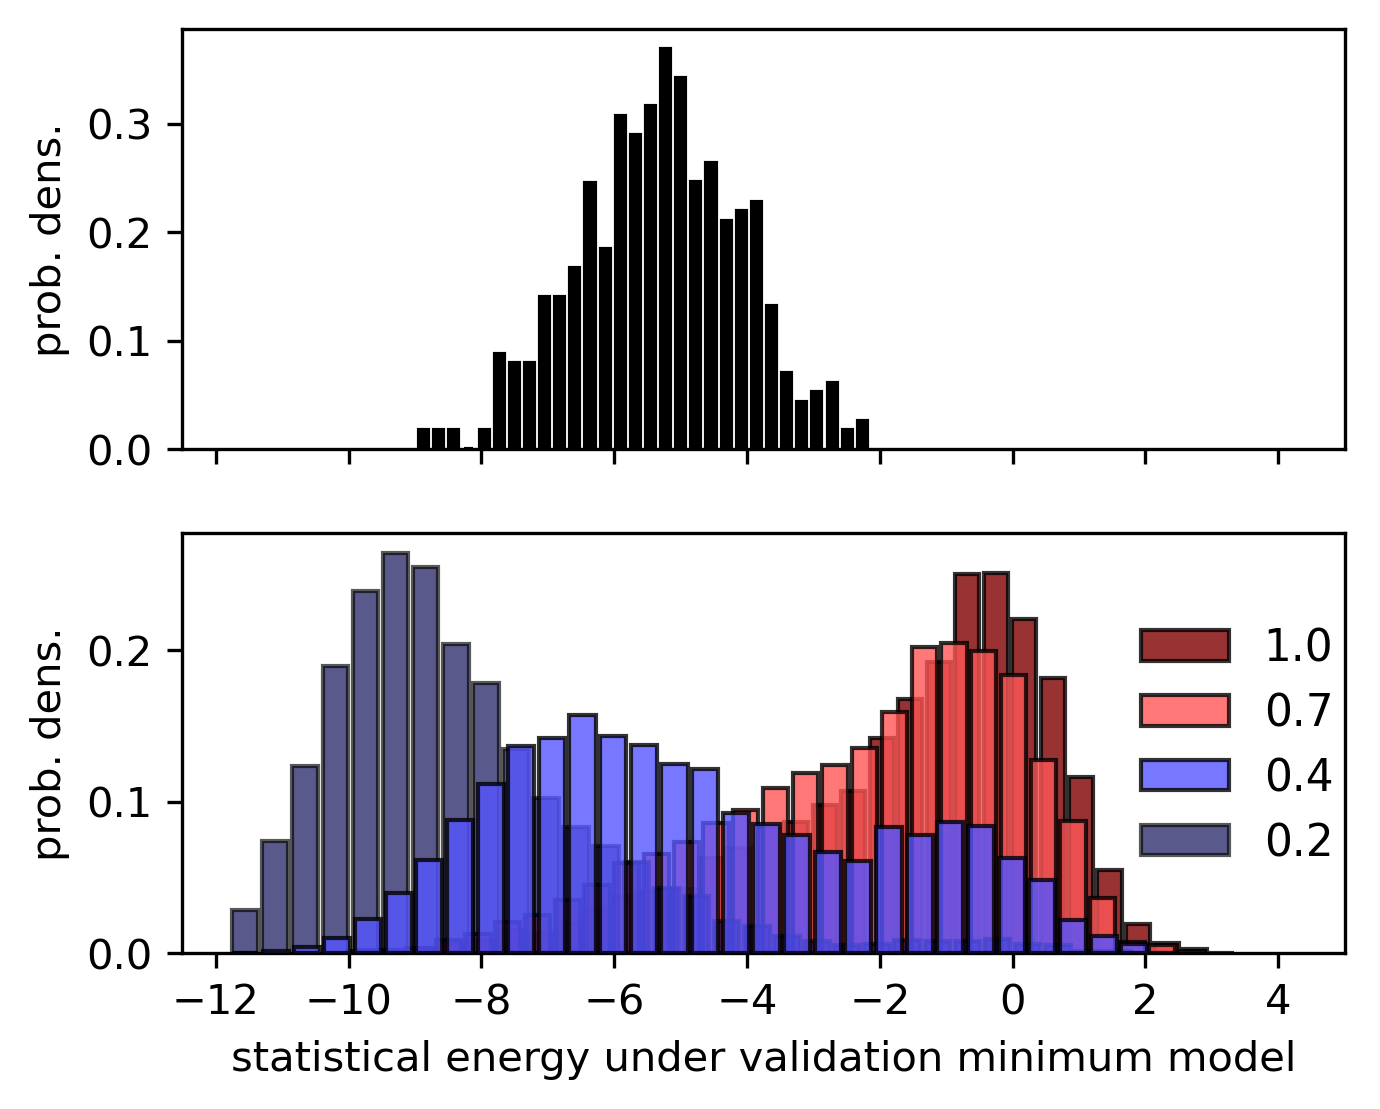

PyObject <matplotlib.legend.Legend object at 0x15f7ee290>

In [132]:
fig, (ax, ax2) = subplots(2,1, dpi=300, figsize=(5,4), sharex=true )
c = ColorMap("seismic")(collect(range(0,1,length(all_Esamps[:,1]))))

logλ = -2

row_idx = findall(loglambdas .== logλ)

Tsamps = collect(0.1:0.1:1)
for (k, cidx,zorder) in zip([10,7,4,2], [10,7,4,1], [1,2,4,3])
    alpha = k == 2 ? 0.65 : 0.8
    im = ax2.hist( all_Esamps[row_idx, k], color=c[cidx,:], density=true, bins=30, ec="k",
        alpha=alpha, rwidth=0.85, label="$(Tsamps[k])", zorder=zorder)
    @show Tsamps[k]
end


# ax2.
ax.hist( Enatural_permodel[row_idx] , color="k", density=true, bins=30, ec="k", rwidth=0.6);
ax2.set_xlabel("statistical energy under validation minimum model")
ax.set_ylabel("prob. dens.")
ax2.set_ylabel("prob. dens.")
ax2.set_xlim(ax2.get_xlim()[1], 5)
ax2.legend(loc=(0.81,0.17),fontsize=10.5, frameon=false)

# if logλ == -2
#     suptitle("statistical energy under validation minimum model")
# else
#     suptitle("logλ = $logλ")
# end

In [ ]:
# N * var(E) / T^2 = C

### heat capacity for different models as fucntion of T 

In [189]:
# fig, (ax, ax2) = subplots(2,1, dpi=300, figsize=(5,4), sharex=true )
# c = ColorMap("seismic")(collect(range(0,1,length(all_Esamps[:,1]))))

# logλ = -2

# row_idx = findall(loglambdas .== logλ)

# Tsamps = collect(0.1:0.1:1)
# for (k, cidx,zorder) in zip([10,7,4,2], [10,7,4,1], [1,2,4,3])
#     alpha = k == 2 ? 0.65 : 0.8
#     im = ax2.hist( all_Esamps[row_idx, k], color=c[cidx,:], density=true, bins=30, ec="k",
#         alpha=alpha, rwidth=0.85, label="$(Tsamps[k])", zorder=zorder)
#     @show Tsamps[k]
# end

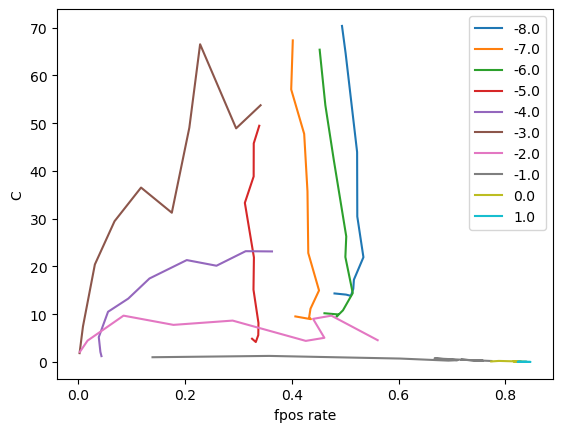

PyObject Text(24.000000000000007, 0.5, 'C')

In [205]:
for k in 1:10
    plot(hmap_fpos[k,:], vec( map( var, all_Esamps[k, :])  ), label="$(loglambdas[k])"  )
end
legend()
xlabel("fpos rate")
ylabel("C")

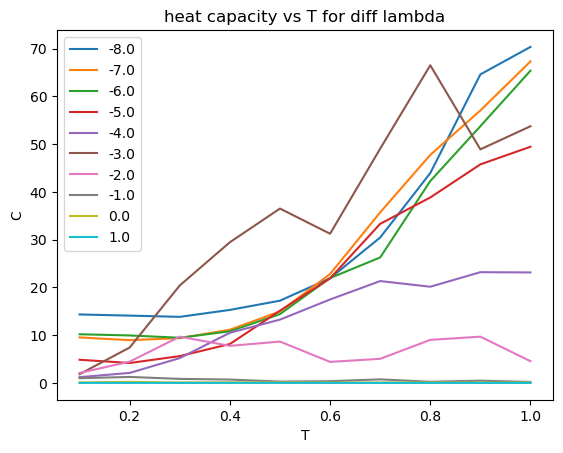

PyObject Text(0.5, 1.0, 'heat capacity vs T for diff lambda')

In [204]:
for k in 1:10
    plot(Tsamps, vec( map( var, all_Esamps[k, :])  ), label="$(loglambdas[k])"  )
end
legend()
ylabel("C")
xlabel("T")
title("heat capacity vs T for diff lambda")

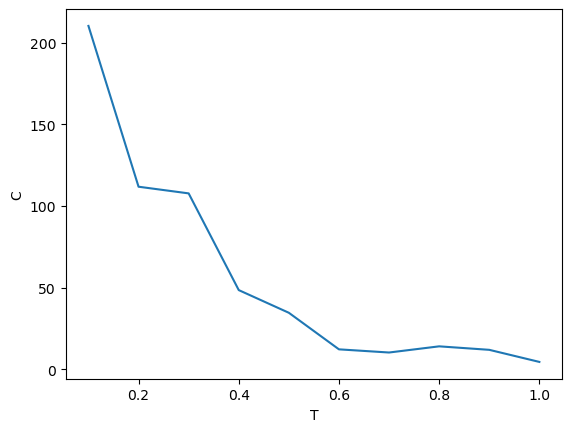

PyObject Text(0.5, 24.0, 'T')

In [195]:
plot(Tsamps,  vec( map( var, all_Esamps[row_idx, : ])  )  ./ Tsamps.^2 )
ylabel("C")
xlabel("T")
title("heat capacity vs T for 

10-element Vector{Float64}:
 14.504408836364746
 10.577470064163208
 10.382594267527264
  6.968483924865723
  5.887674331665039
  3.5023840268452964
  3.2132744789123535
  3.7557584047317505
  3.459817303551568
  2.135981559753418

1-element Vector{Float64}:
 0.7

In [105]:
trace=allsamps[1,kk][:ais_trace]

fig, ax = subplots(2,2, figsize=(6,6))
ax= ax[:]

ax[1].plot(collect(1:length(trace[:meanEᵦ₍ᵢ₋₁₎])), 
    trace[:meanEᵦ₍ᵢ₋₁₎], c="r")
ax[1].errorbar(collect(1:length(trace[:meanEᵦ₍ᵢ₋₁₎])), 
    trace[:meanEᵦ₍ᵢ₋₁₎], yerr=trace[:stdEᵦ₍ᵢ₋₁₎], alpha=0.1)
ax[1].set_title("Emean per sample step")

ax[2].plot(collect(1:length(trace[:Ƶ])), 
    trace[:Ƶ], c="r")
ax[2].set_title("Zi/Zi-1")

ax[3].plot(collect(1:length(trace[:sample_steps_used])), trace[:sample_steps_used])
ax[3].set_title("sample steps used per epoch")

ax[4].plot(collect(1:length(trace[:accrate])), trace[:accrate])
ax[4].set_title("accept rate per sample step")

suptitle("

allsamps[1,kk][:fit_entropy]

LoadError: syntax: incomplete: invalid string syntax

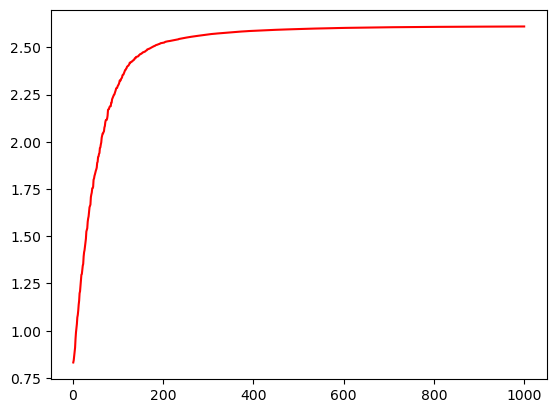

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x3b5d8d1e0>

In [84]:
for k in 1:10
 @show allsamps[k,1][:fit_entropy]
end

(allsamps[k, 1])[:fit_entropy] = Dict{Symbol, Any}(:logZ => 960.76776f0, :entropy => 2.338562f0, :meanE => -958.4292f0)
(allsamps[k, 1])[:fit_entropy] = Dict{Symbol, Any}(:logZ => 722.6147f0, :entropy => -11.397644f0, :meanE => -734.0123f0)
(allsamps[k, 1])[:fit_entropy] = Dict{Symbol, Any}(:logZ => 832.6141f0, :entropy => -2.2618408f0, :meanE => -834.8759f0)
(allsamps[k, 1])[:fit_entropy] = Dict{Symbol, Any}(:logZ => 591.6085f0, :entropy => -3.6532593f0, :meanE => -595.2618f0)
(allsamps[k, 1])[:fit_entropy] = Dict{Symbol, Any}(:logZ => 358.52643f0, :entropy => 3.4477844f0, :meanE => -355.07864f0)
(allsamps[k, 1])[:fit_entropy] = Dict{Symbol, Any}(:logZ => 234.36948f0, :entropy => 5.097809f0, :meanE => -229.27167f0)
(allsamps[k, 1])[:fit_entropy] = Dict{Symbol, Any}(:logZ => 120.09403f0, :entropy => -1.5153961f0, :meanE => -121.60943f0)
(allsamps[k, 1])[:fit_entropy] = Dict{Symbol, Any}(:logZ => 54.28064f0, :entropy => -88.53427f0, :meanE => -142.81491f0)
(allsamps[k, 1])[:fit_entropy]

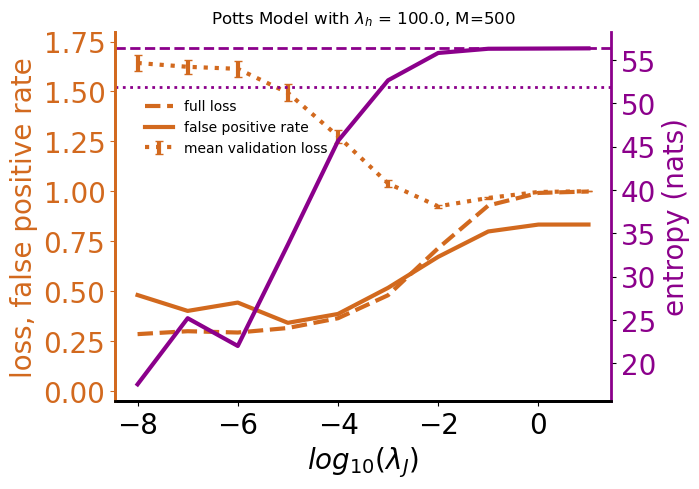

PyObject Text(0.5, 1.0, 'Potts Model with $ \\lambda_h$ = 100.0, M=500')

In [91]:
function plot_losses( ax, losses, calc_f_pos, calc_H, rand_ent, ylims, true_ent)
    lambdas = map(y -> log10(y), map( y -> y[1]  , losses[:,1])) 

    c1="chocolate"
    
    ax.errorbar( lambdas , losses[:,2], yerr = losses[:,3],
        label = "mean validation loss", linestyle=":", color=c1, capsize=3, linewidth=3)
    ax.plot(lambdas, losses[:,4], label = "full loss", linestyle="dashed", color=c1 , linewidth=3)
    # ax.grid( alpha=0.5 )
    
    ax.set_ylim( ylims )
    ax.set_ylabel( "loss" , color=c1, fontsize=20 )
    
    ax.tick_params(axis="y", labelcolor=c1, color=c1)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=20)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=20)
    ax.spines["left"].set_color(c1)
    ax.spines["left"].set_linewidth(2)
    ax.spines["right"].set_linewidth(0)
    ax.spines["top"].set_linewidth(0)
    ax.spines["bottom"].set_linewidth(2)
    
     calc_f_pos && ( ax.plot( lambdas, losses[:,5] , label = "false positive rate", 
            linestyle="solid", color=c1, linewidth=3, zorder=0) ;
        ax.set_ylabel( "loss, false positive rate" , color=c1, fontsize=20 ) )
    ax.legend(frameon=false, loc=(0.05,0.65)) 
    
    if calc_H==true

        ax2 = ax.twinx()
        c2 = "darkmagenta"
        ax2.plot(lambdas, losses[:,6], color=c2, zorder=0, linewidth= 3)
        
        ax2.set_xlim(ax.get_xlim()...)
        ax2.set_ylabel( "entropy (nats)" , color=c2, fontsize=20)
        ax2.tick_params(axis="y", labelcolor=c2)
        ax2.hlines(rand_ent, ax2.get_xlim()...,
            label="random sequence", linestyle="dashed", linewidth=2, color=c2)
        ax2.hlines(true_ent, ax2.get_xlim()...,
            label="ground truth", linestyle="dotted", linewidth=2, color=c2)
        
        # ax2.legend(loc="upper left", frameon=false, labelcolor=c2)
        ax2.set_yticklabels(ax2.get_yticklabels(), fontsize=20)
        ax2.spines["right"].set_color(c2)
        ax2.spines["left"].set_color(c1)
        ax2.spines["left"].set_linewidth(2)
        ax2.spines["right"].set_linewidth(2)
        ax2.spines["top"].set_linewidth(0)
        ax2.spines["bottom"].set_linewidth(2)
    end
end


fig, ax = subplots( dpi=100)
rand_ent=35*log(5)
true_ent = H_toymodel(init_toy_model(Tsec)...)[:Htotal]
ylims =( -0.05,1.8 )

plot_losses( ax, losses_pw,  true , true, rand_ent, ylims, true_ent)
ax.set_xlabel(L"log_{10}(\lambda_J)", fontsize=20)
title("Potts Model with "*L" \lambda_h"*" = $(best_pw_reg_h[1]), M=$(M)" )
# savefig(fitsdir("pairwise_learning_curve.png"))


# fig, ax = subplots(dpi=200)
# plot_losses( ax, losses_rbm, true, true )
# ax.set_xlabel(L"log_{10}(\lambda_W)")
# title("rbm with P = $best_rbm_P, lambda_h = $best_rbm_reg_h, M=$(M)")
# savefig(fitsdir("rbm_learning_curve.png"))

# temperature dependance

In [128]:
fitsdir(args...) = sampledir("fitted_models", @sprintf("sector_temp=%.2f", 
        Tsec), args...)
params_sets = Dict{Symbol,Any}(
    :Pairwise => Dict{Symbol, Any}(
        :reg_J => [ (10f0^log10λ, 2) for log10λ ∈ -2:-2 ],
        :reg_h => [ (10f0^log10λ, 2) for log10λ ∈  2:2  ],
        :epochs => 20_000,
        :showevery => 500,
        :progTol => 10^-6
    )
)
d = dict_list(params_sets[:Pairwise])[1]
Tsamps=collect(1:-.1:0.1)
samps = Vector{Any}(undef, length(Tsamps))
for (k,Tsamp) in enumerate(Tsamps)
    samps[k] = BSON.load( fitsdir(savename(d)*"_samples_T=$(Tsamp).bson"))[:results] 
end

In [129]:
# get model
# get synthetic data
# get samples from model at different temperatures

In [130]:
samps[1]

Dict{Symbol, Any} with 3 entries:
  :z_from_fit  => [0.0 0.0 … 0.0 0.0; 1.0 1.0 … 1.0 0.0; … ; 0.0 0.0 … 0.0 0.0;…
  :fit_entropy => Dict{Symbol, Any}(:logZ=>56.7149, :entropy=>55.794, :meanE=>-…
  :ais_trace   => Dict{Symbol, Any}(:stdEᵦ₍ᵢ₋₁₎=>Float32[0.0748926, 0.0749696, …

In [131]:
H = zeros(Float32, length(Tsamps))
f_pos = zeros(Float32, length(Tsamps))

θpw, θsec =  init_toy_model( Tsec )
sec_energy_buffer = SectorEnergyBuffer(θsec, 5000)

for k in 1:length(Tsamps)
    H[k] = samps[k][:fit_entropy][:entropy]
    z = samps[k][:z_from_fit]
    E_under_gt = sectorenergy(z[:,29:35,:], θsec, sec_energy_buffer)
    n_fpos = E_under_gt .== Inf32
    # @show n_fpos
    
    f_pos[k]= sum(n_fpos)/length(n_fpos)
end



In [132]:
f_pos

10-element Vector{Float32}:
 0.675
 0.6636
 0.6176
 0.5652
 0.5006
 0.3894
 0.1888
 0.0214
 0.0
 0.0

In [ ]:
function plot_all(ax, xlims, ylims, xxlabel, ax1label, calc_ent, x, ents, rand_ent, true_ent)
    c1="chocolate"
    ax.set_ylim(ylims)
    # ax.set_ylabel( ax1label, fontsize=20, c=c1)
    ax.set_xlim(xlims)
    ax.set_xlabel(xxlabel, fontsize=20)
    ax.tick_params(axis="y", labelcolor=c1, color=c1)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=20)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=20)
    ax.spines["left"].set_color(c1)
    ax.spines["left"].set_linewidth(2)
    ax.spines["right"].set_linewidth(0)
    ax.spines["top"].set_linewidth(0)
    ax.spines["bottom"].set_linewidth(2)
    ax.set_ylabel( "false positive rate" , color=c1, fontsize=20 ) 
    if calc_ent==true

        ax2 = ax.twinx()
        c2 = "darkmagenta"
        ax2.plot(x, ents, color=c2, zorder=0, linewidth= 3)
        ax2.set_ylabel( "entropy (nats)" , color=c2, fontsize=20)
        # ax2.set_ylim(0,rand_ent+3)
        ax2.tick_params(axis="y", labelcolor=c2)
        ax2.hlines(rand_ent, ax2.get_xlim()...,
            label="random sequence", linestyle="dashed", linewidth=2, color=c2)
        ax2.hlines(true_ent, ax2.get_xlim()...,
            label="ground truth", linestyle="dotted", linewidth=2, color=c2)

        ax2.legend(loc="lower right", frameon=false, labelcolor=c2, fontsize=16)
        ax2.set_yticklabels(ax2.get_yticklabels(), fontsize=20)
        ax2.spines["right"].set_color(c2)
        ax2.spines["left"].set_color(c1)
        ax2.spines["left"].set_linewidth(2)
        ax2.spines["right"].set_linewidth(2)
        ax2.spines["top"].set_linewidth(0)
        ax2.spines["bottom"].set_linewidth(2)
    end
end


plot_all (generic function with 1 method)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


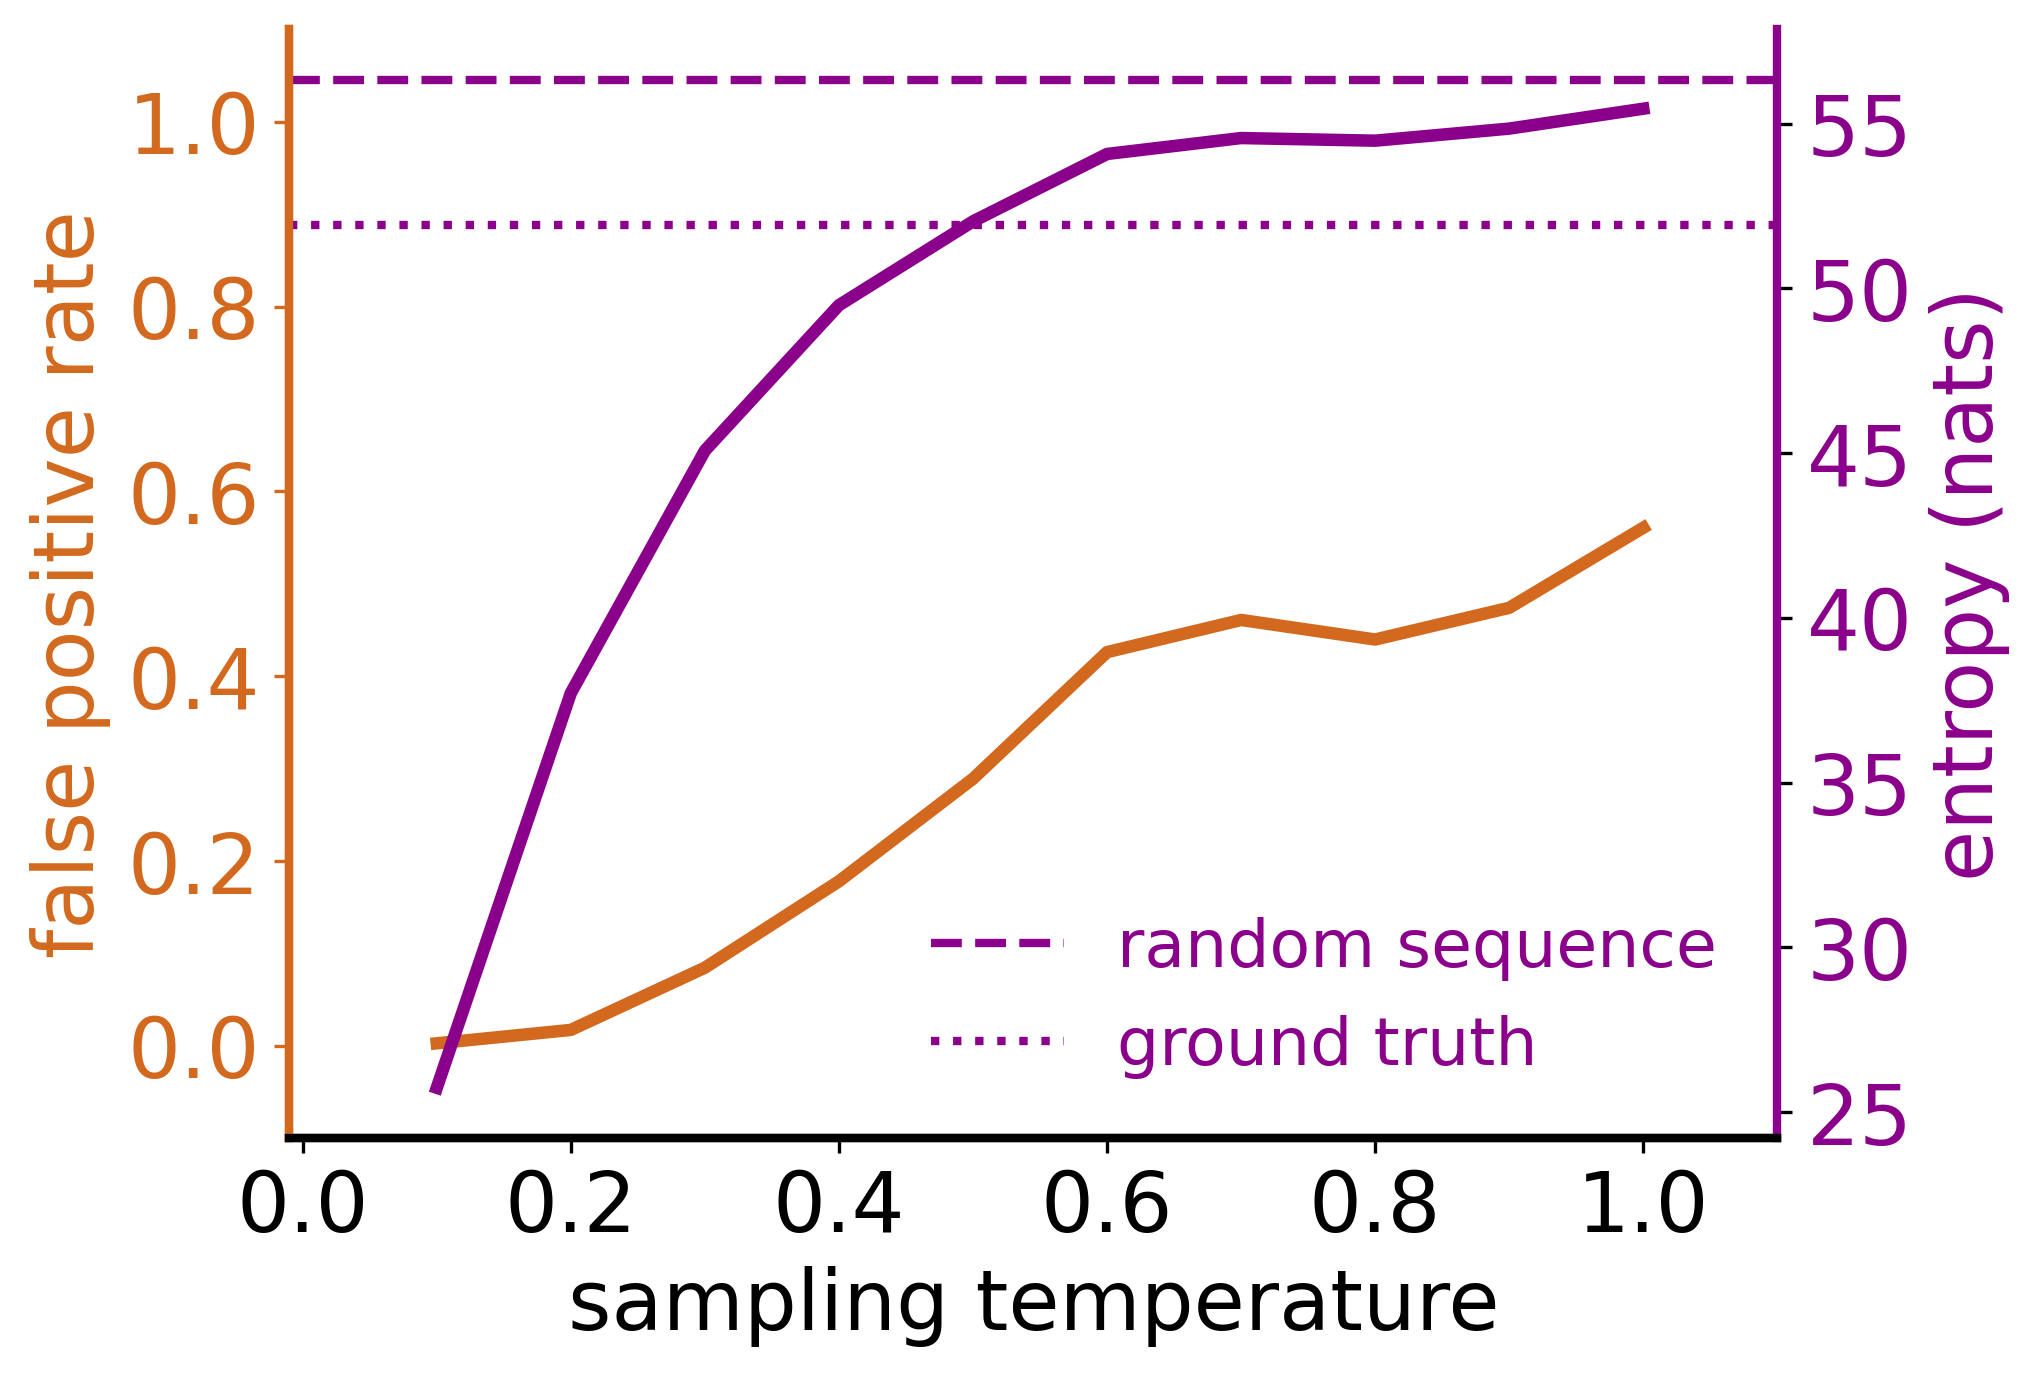

PyObject <matplotlib.legend.Legend object at 0x33a5ae410>

In [148]:
fig,ax =subplots(dpi=300)
xlims = (-0.01,1.1)
ylims = (-0.1,1.1)
xxlabel = "sampling temperature"
ax1label = "false positive rate" 
sss = collect(1:10)
x = Tsamps[sss]
calc_ent = true
rand_ent = 35*log(5)
true_ent = H_toymodel(init_toy_model(Tsec)...)[:Htotal]
# ents = H

plot_all(ax, xlims, ylims, xxlabel, ax1label, calc_ent, x, 
    hmap_ent[7,:][sss], rand_ent, true_ent)
ax.plot(x, hmap_fpos[7,:][sss], color= "chocolate", linewidth=3)
ax.legend(frameon=false)

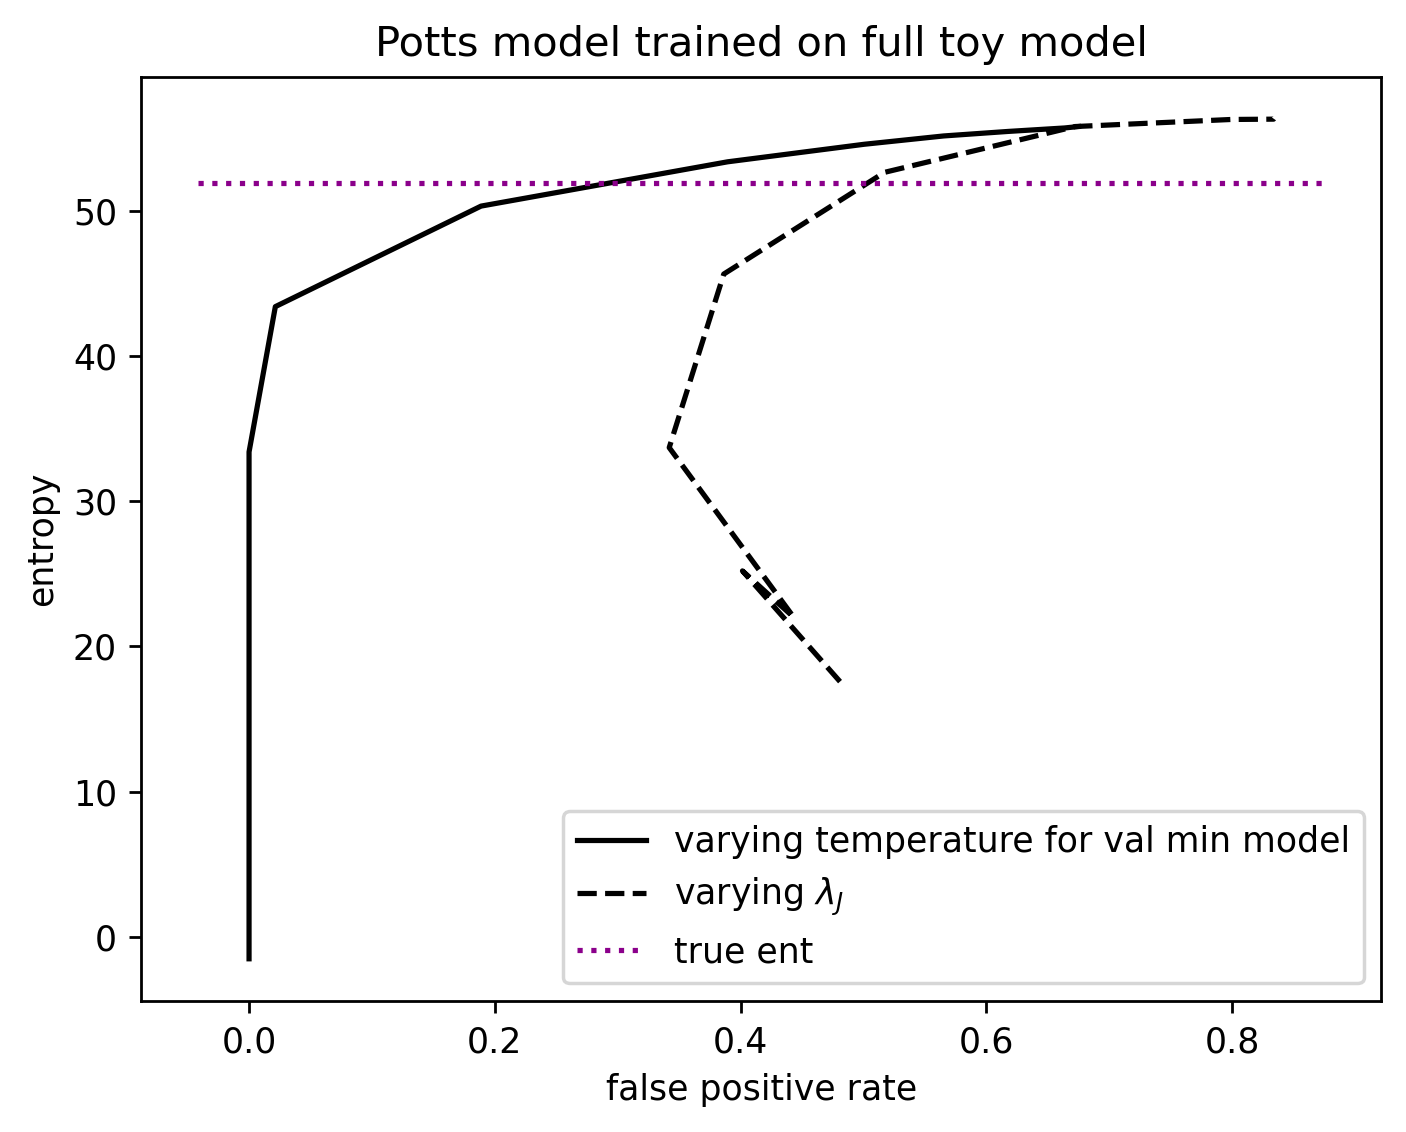

PyObject <matplotlib.legend.Legend object at 0x3ebf26d40>

In [421]:
fig, ax = subplots(dpi=250)
plot(f_pos, ents, label="varying temperature for val min model", color="k")
xlabel("false positive rate")
ylabel("entropy")
plot(losses_pw[:,5] , losses_pw[:,6], label="varying "*L"\lambda_J", color="k", linestyle="dashed")
title("Potts model trained on full toy model")
true_ent = H_toymodel(init_toy_model(Tsec)...)[:Htotal]
hlines(true_ent, ax.get_xlim()..., label="true ent", color="darkmagenta", linestyle="dotted")
legend()


In [135]:
function plot_losses_only( ax, losses, rand_ent, ylims, true_ent;
    c1 ="chocolate", c2="darkmagenta")
    lambdas = map(y -> log10(y), map( y -> y[1]  , losses[:,1])) 

    
    ax.errorbar( lambdas , losses[:,2], yerr = losses[:,3],
        label = "mean validation loss", linestyle=":", color=c1, capsize=3, linewidth=3)
    ax.plot(lambdas, losses[:,4], label = "training loss", color=c1 , linewidth=3)
    # ax.grid( alpha=0.5 )
    # linestyle="dashed"
    
    ax.set_ylim( ylims )
    ax.set_ylabel( "loss" , color=c1, fontsize=20 )
    
    ax.tick_params(axis="y", labelcolor=c1, color=c1)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=20)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=20)
    # ax.set_xticks([])
    ax.spines["left"].set_color(c1)
    ax.spines["left"].set_linewidth(2)
    ax.spines["right"].set_linewidth(0)
    ax.spines["top"].set_linewidth(0)
    ax.spines["bottom"].set_linewidth(2)
    
    
end

function plot_ent_fpos(ax, losses, rand_ent, ylims, true_ent;
    c1 ="chocolate", c2="darkmagenta", calc_H=true, calc_f_pos=true)
    
    lambdas = map(y -> log10(y), map( y -> y[1]  , losses[:,1]))
    
    calc_f_pos && ( ax.plot( lambdas, losses[:,5] , label = "false positive rate", 
            linestyle="solid", color=c1, linewidth=3, zorder=0) ;
        ax.set_ylabel( "false positive rate" , color=c1, fontsize=20 ) )
    
    ax.set_ylim( ylims )
    ax.tick_params(axis="y", labelcolor=c1, color=c1)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=20)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=20)
    ax.spines["left"].set_color(c1)
    ax.spines["left"].set_linewidth(2)
    ax.spines["right"].set_linewidth(0)
    ax.spines["top"].set_linewidth(0)
    ax.spines["bottom"].set_linewidth(2)
    # ax.legend(frameon=false, loc="lower right") 
    
    if calc_H==true

        ax2 = ax.twinx()
        ax2.plot(lambdas, losses[:,6], color=c2, zorder=0, linewidth= 3)
        
        ax2.set_xlim(ax.get_xlim()...)
        ax2.set_ylabel( "entropy (nats)" , color=c2, fontsize=20)
        ax2.tick_params(axis="y", labelcolor=c2)
        ax2.hlines(rand_ent, ax2.get_xlim()...,
            label="random sequence", linestyle="dashed", linewidth=2, color=c2)
        ax2.hlines(true_ent, ax2.get_xlim()...,
            label="ground truth", linestyle="dotted", linewidth=2, color=c2)
        
        # ax2.legend(loc="lower right", frameon=false, labelcolor=c2)
        ax2.set_yticklabels(ax2.get_yticklabels(), fontsize=20)
        ax2.spines["right"].set_color(c2)
        ax2.spines["left"].set_color(c1)
        ax2.spines["left"].set_linewidth(2)
        ax2.spines["right"].set_linewidth(2)
        ax2.spines["top"].set_linewidth(0)
        ax2.spines["bottom"].set_linewidth(2)
    end
end

fig = figure(dpi=300, figsize=(12,12))
ax1 = fig.add_subplot(2, 2, 1)
ax3 = fig.add_subplot(2, 2, 3, sharex = ax1)
ax2 = fig.add_subplot(2, 2, 2)
ax4 = fig.add_subplot(2, 2, 4)

plt.subplots_adjust(left=0.1,
                    bottom=0.2,
                    right=0.9,
                    top=0.8,
                    wspace=0.5,
                    hspace=0.3)
rand_ent=35*log(5)
true_ent = H_toymodel(init_toy_model(Tsec)...)[:Htotal]

ylims =( 0.1,1.8 )
plot_losses_only( ax1, losses_pw, rand_ent, ylims, true_ent; 
        c1="k")

ylims =( -0.05,1. )
plot_ent_fpos( ax3, losses_pw, rand_ent, ylims, true_ent )

ax3.set_xlabel(L"log_{10}(\lambda_J)", fontsize=20)
# title("Potts Model with "*L" \lambda_h"*" = $(best_pw_reg_h[1]), M=$(M)" )
# savefig(fitsdir("pairwise_learning_curve.png"))


plot_all(ax2, xlims, ylims, xxlabel, ax1label, calc_ent, x, 
    ents, rand_ent, true_ent)
ax2.plot(Tsamps, f_pos, color= "chocolate", linewidth=3)

ax4.plot(f_pos, ents, label="varying temperature for val min model", color="k", linewidth=3)
ax4.set_xlabel("false positive rate", fontsize=20)
ax4.set_ylabel("entropy",fontsize=20)
ax4.plot(losses_pw[:,5] , losses_pw[:,6], label="varying "*L"\lambda_J", color="k", linestyle="dashed", 
    linewidth=3)
# ax4.set_title("Potts model trained on full toy model")
true_ent = H_toymodel(init_toy_model(Tsec)...)[:Htotal]
ax4.hlines(true_ent, ax.get_xlim()..., label="true ent", color="darkmagenta", linestyle="dotted",
 linewidth=3)
ax4.legend()
ax4.set_yticklabels(ax.get_yticklabels(), fontsize=20)
ax4.set_xticklabels(ax.get_xticklabels(), fontsize=20)



# fig, ax = subplots(dpi=200)
# plot_losses( ax, losses_rbm, true, true )
# ax.set_xlabel(L"log_{10}(\lambda_W)")
# title("rbm with P = $best_rbm_P, lambda_h = $best_rbm_reg_h, M=$(M)")
# savefig(fitsdir("rbm_learning_curve.png"))

LoadError: UndefVarError: ents not defined

In [54]:
losses_pw[:,6] = hmap_ent[:,10]
losses_pw[:,5] = hmap_fpos[:,10]

10-element Vector{Float64}:
 0.4015
 0.45416666666666666
 0.38566666666666666
 0.3408333333333333
 0.29433333333333334
 0.38133333333333336
 0.5371666666666667
 0.7706666666666667
 0.8338333333333333
 0.8286666666666667

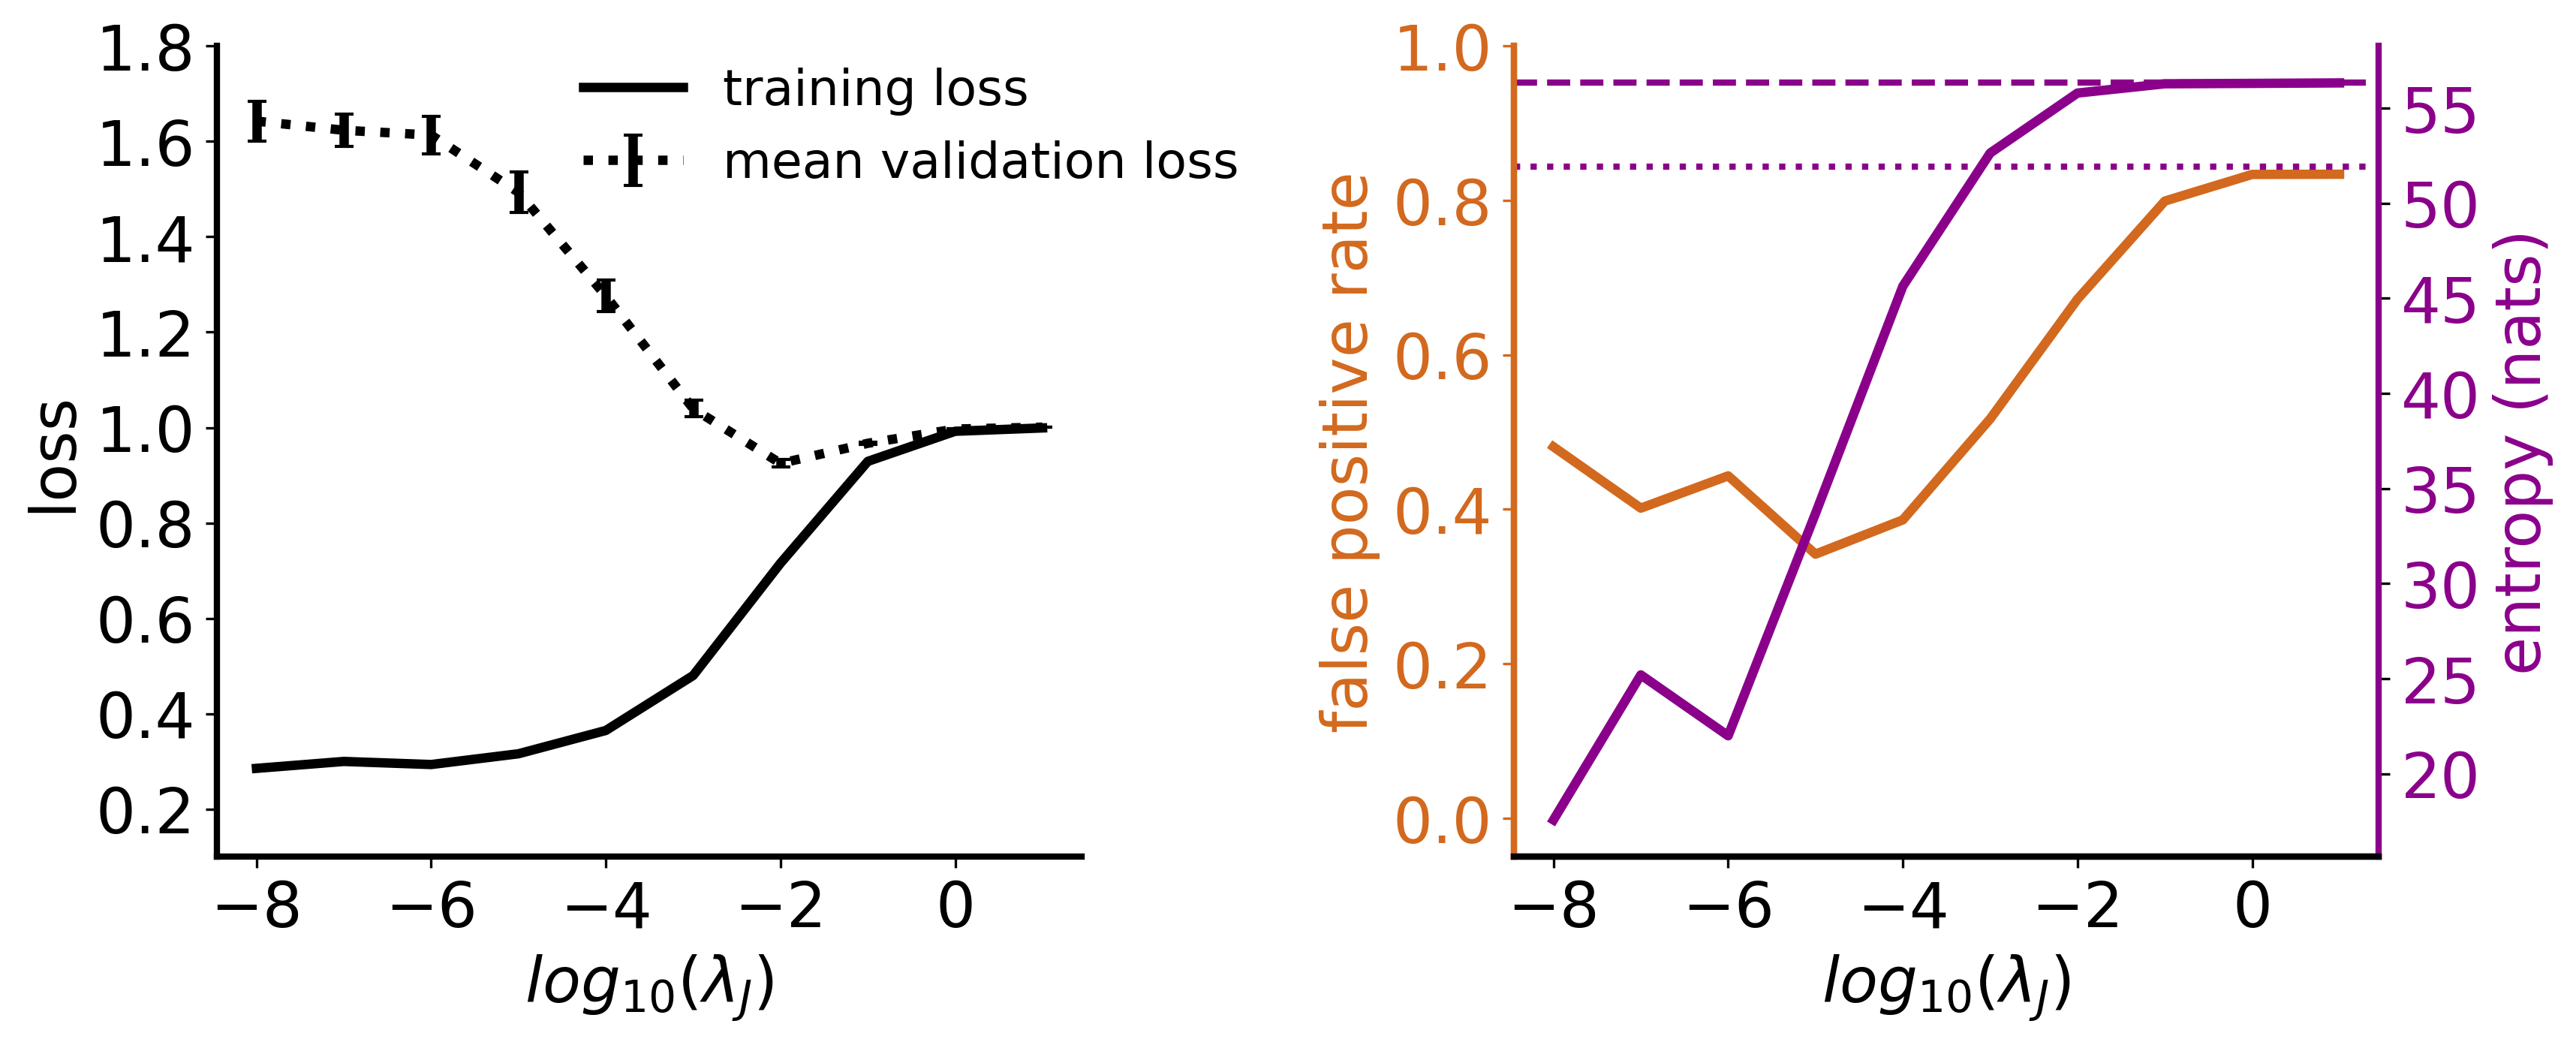

PyObject Text(0.5, 123.90000000000002, '$log_{10}(\\lambda_J)$')

In [146]:

fig = figure(dpi=300, figsize=(12,6))
ax1 = fig.add_subplot(1, 2, 1)
ax3 = fig.add_subplot(1, 2, 2, sharex = ax1)


plt.subplots_adjust(left=0.1,
                    bottom=0.2,
                    right=0.9,
                    top=0.8,
                    wspace=0.5,
                    hspace=0.3)
rand_ent=35*log(5)
true_ent = H_toymodel(init_toy_model(Tsec)...)[:Htotal]

ylims =( 0.1,1.8 )
plot_losses_only( ax1, losses_pw, rand_ent, ylims, true_ent; 
        c1="k")

ylims =( -0.05,1. )
plot_ent_fpos( ax3, losses_pw, rand_ent, ylims, true_ent )


ax1.set_xlabel(L"log_{10}(\lambda_J)" , fontsize=20)
ax1.legend(frameon=false, loc=(0.4,0.8), fontsize=16)

ax3.set_xlabel(L"log_{10}(\lambda_J)" , fontsize=20)
# ax3.hlines(true_ent, ax.get_xlim()... , label="true ent", color="darkmagenta", linestyle="dotted",
 # linewidth=3)
# ax3.legend(loc="lower right")

In [22]:
losses_pw[:,5] 

10-element Vector{Any}:
 0.4809
 0.4015
 0.4433
 0.3419
 0.3863
 0.5171
 0.6722
 0.7992
 0.8337
 0.8339

In [23]:
H_toymodel(init_toy_model(Tsec)...)

Dict{Symbol, Any} with 4 entries:
  :Hisos  => 15.5483
  :Hnoise => 28.9699
  :Hsec   => 7.40194
  :Htotal => 51.9201

# Pull sec only model

In [29]:
M=500 #nsamples
Tsec=0.4

modls = [:Pairwise , :RBM]#, :SRBM]
params_sets = Dict{Symbol,Any}(
    :Pairwise => Dict{Symbol, Any}(
        :reg_J => [(10f0^log10λ, 2) for log10λ ∈ -8:1],
        :reg_h => [(10f0^log10λ, 2) for log10λ ∈ 0:0],
        :epochs => 20_000,
        :showevery => 500,
        :progTol => 10^-6
    )
     ,
     :RBM => Dict{Symbol, Any}(
         :reg_W => [(10f0^log10λ, 2) for log10λ ∈ -8:-1],
         :reg_h => [(10f0^log10λ, 2) for log10λ ∈ 0:0],
         :P => [50],
         :epochs => 20_000,
         :showevery => 500,
         :progTol => 10^-6
     )
)

sampledir(args...) = datadir("toysector_q=5", 
    "nsamples=$(M)", args...)

z = BSON.load(
    sampledir( @sprintf("sector_temp=%.2f_samples.bson", Tsec) ) 
    )[:samples];
z = Float32.(z)
q,N,_=size(z)

(5, 35, 500)

In [603]:
fitsdir(args...) = sampledir("fitted_models_sec_only", @sprintf("sector_temp=%.2f", 
        Tsec), args...)

fitsdir (generic function with 1 method)

In [604]:
nsamples_for_fpos = 10_000
θpw, θsec =  init_toy_model( Tsec )
q,N = (5,7)
all_states_buffer = (N*log(q)) < 21. ? AllStatesBuffer( q, N, θsec, θsec.FloatType ) : nothing
sec_energy_buffer = SectorEnergyBuffer( θsec , nsamples_for_fpos )
Htrue = H_toymodel( θpw, θsec )
# q,N,_=size(z)

Dict{Symbol, Any} with 4 entries:
  :Hisos  => 15.5483
  :Hnoise => 28.9699
  :Hsec   => 7.40194
  :Htotal => 51.9201

In [605]:
sweep_dicts = Dict{Symbol, Any}()
for mdl in modls
    sweep_dicts[mdl] = dict_list( params_sets[mdl] )
end
    

### for each model type (pairwise, rbm, sRBM)
for mdl in modls
    mdldir(args...) = fitsdir(string(mdl), args...)
    isdir(mdldir()) || mkpath(mdldir())
    swp_ds = sweep_dicts[mdl] #alias
    @printf "\n"
    @printf "%s model\n" string(mdl)
    for d in sweep_dicts[mdl]
        
        @printf "%s\n" savename(d)
	    if isfile(mdldir(savename(d)*".bson"))
            vecθ = BSON.load(mdldir(savename(d)*"_model.bson"))[:vecθ]
            P = haskey(d, :P) ? d[:P] : 0
            θ = initθ(mdl, q, N, P )
            copyto!(θ, vecθ)
            d[:θ] = θ
            merge!(d, BSON.load(mdldir(savename(d)*".bson"))[:d])
        end
    end
end


Pairwise model
L2_regh=1e0.0_regJ=1e-8.0
L2_regh=1e0.0_regJ=1e-7.0
L2_regh=1e0.0_regJ=1e-6.0
L2_regh=1e0.0_regJ=1e-5.0
L2_regh=1e0.0_regJ=1e-4.0
L2_regh=1e0.0_regJ=1e-3.0
L2_regh=1e0.0_regJ=1e-2.0
L2_regh=1e0.0_regJ=1e-1.0
L2_regh=1e0.0_regJ=1e0.0
L2_regh=1e0.0_regJ=1e1.0

RBM model
L2_regh=1e0.0_P=50_L2_regW=1e-8.0
L2_regh=1e0.0_P=50_L2_regW=1e-7.0
L2_regh=1e0.0_P=50_L2_regW=1e-6.0
L2_regh=1e0.0_P=50_L2_regW=1e-5.0
L2_regh=1e0.0_P=50_L2_regW=1e-4.0
L2_regh=1e0.0_P=50_L2_regW=1e-3.0
L2_regh=1e0.0_P=50_L2_regW=1e-2.0
L2_regh=1e0.0_P=50_L2_regW=1e-1.0


In [606]:
# for d in sweep_dicts[:Pairwise]
#     im=im20(get_fro(d[:θ].J))
#     title(savename(d))
    
#     # θpw_seconly = Pairwise(d[:θ].J[:,29:35,:,29:35], d[:θ].h[:,29:35])
#     # f_pos_other,_ = get_f_pos_rate(θsec, θpw_seconly, sec_energy_buffer, all_states_buffer, M)
#     xlabel("f_pos = $(d[:false_pos_rate])") #and f_pos_other=$(f_pos_other)")
#     colorbar(im)
# end

In [607]:
# sweep_dicts[:RBM][1][:θ].b

In [608]:
# for d in sweep_dicts[:RBM]
#     im=im20(get_fro(d[:θ].W))
#     title(savename(d))
    
#     # θrbm_seconly = RBM(d[:θ].W[:,:,29:35], d[:θ].h[:,29:35], d[:θ].b )
#     # f_pos_other,_ = get_f_pos_rate(θsec, θrbm_seconly, sec_energy_buffer, all_states_buffer, M)
#     xlabel("f_pos = $(d[:false_pos_rate])")# and f_pos_other=$(f_pos_other)")
#     colorbar(im)
# end

In [609]:
losses_pw   = pull_from_sweep(sweep_dicts[:Pairwise], 
    [:reg_h, :reg_J, :mean𝕍] 
    )
best_idx_pw = findmin(losses_pw[:,end])[2]
best_pw_reg_h, best_pw_reg_J, _ = losses_pw[best_idx_pw, :]

losses_rbm  = pull_from_sweep(sweep_dicts[:RBM], 
    [:reg_h, :reg_W, :P, :mean𝕍] 
    )
best_idx_rbm = findmin(losses_rbm[:,end])[2]
best_rbm_reg_h, best_rbm_reg_W, best_rbm_P, _ = losses_rbm[best_idx_rbm, :]
to_pull_from_sweep = [:reg_J, :mean𝕍, :std𝕍, :inloss ]
( push!( to_pull_from_sweep, :false_pos_rate ) )
( push!( to_pull_from_sweep, :fit_entropy  ) )
( push!( to_pull_from_sweep, :true_entropy  ) )

losses_pw   = pull_from_sweep(sweep_dicts[:Pairwise], 
    to_pull_from_sweep ;
    reg_h = best_pw_reg_h
    )

# popfirst!(to_pull_from_sweep)
# pushfirst!(to_pull_from_sweep, :reg_W)
# losses_rbm   = pull_from_sweep(sweep_dicts[:RBM], 
#     to_pull_from_sweep ;
#     reg_h = best_rbm_reg_h,
#     P = best_rbm_P
#     )

10×7 Matrix{Any}:
 (1.0f-8, 2)  0.509776  0.0322762   0.347137  0.0333451   3.49865  7.40194
 (1.0f-7, 2)  0.507954  0.0309568   0.347497  0.0388381   3.79352  7.40194
 (1.0f-6, 2)  0.507771  0.0324075   0.346917  0.0281751   3.20723  7.40194
 (1.0f-5, 2)  0.507077  0.0306117   0.346945  0.0274652   3.1424   7.40194
 (0.0001, 2)  0.497771  0.0292191   0.348666  0.0639067   4.81334  7.40194
 (0.001, 2)   0.46532   0.0238838   0.36064   0.226002    8.32333  7.40194
 (0.01, 2)    0.457675  0.0179425   0.412659  0.490251   10.563    7.40194
 (0.1, 2)     0.610753  0.0117149   0.596504  0.718309   11.1899   7.40194
 (1.0, 2)     0.904477  0.00497675  0.900291  0.815296   11.2453   7.40194
 (10.0, 2)    0.991402  0.0022676   0.987556  0.831258   11.2544   7.40194

In [610]:
function plot_losses( ax, losses, calc_f_pos, calc_H, rand_ent, ylims)
    lambdas = map(y -> log10(y), map( y -> y[1]  , losses[:,1])) 

    c1="chocolate"
    
    ax.errorbar( lambdas , losses[:,2], yerr = losses[:,3],
        label = "mean validation loss", linestyle=":", color=c1, capsize=3, linewidth=3)
    ax.plot(lambdas, losses[:,4], label = "full loss", linestyle="dashed", color=c1 , linewidth=3)
    # ax.grid( alpha=0.5 )
    
    ax.set_ylim( ylims )
    ax.set_ylabel( "loss" , color=c1, fontsize=20 )
    
    ax.tick_params(axis="y", labelcolor=c1, color=c1)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=20)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=20)
    ax.spines["left"].set_color(c1)
    ax.spines["left"].set_linewidth(2)
    ax.spines["right"].set_linewidth(0)
    ax.spines["top"].set_linewidth(0)
    ax.spines["bottom"].set_linewidth(2)
    
     calc_f_pos && ( ax.plot( lambdas, losses[:,5] , label = "false positive rate", 
            linestyle="solid", color=c1, linewidth=3, zorder=0) ;
        ax.set_ylabel( "loss, false positive rate" , color=c1, fontsize=20 ) )
    ax.legend(frameon=false, loc=(0.05,0.65)) 
    
    if calc_H==true

        ax2 = ax.twinx()
        c2 = "darkmagenta"
        ax2.plot(lambdas, losses[:,6], color=c2, zorder=0, linewidth= 3)
        
        ax2.set_xlim(ax.get_xlim()...)
        ax2.set_ylabel( "entropy (nats)" , color=c2, fontsize=20)
        ax2.tick_params(axis="y", labelcolor=c2)
        ax2.hlines(rand_ent, ax2.get_xlim()...,
            label="random sequence", linestyle="dashed", linewidth=2, color=c2)
        ax2.hlines(losses[:,7][1], ax2.get_xlim()...,
            label="ground truth", linestyle="dotted", linewidth=2, color=c2)
        
        # ax2.legend(loc="upper left", frameon=false, labelcolor=c2)
        ax2.set_yticklabels(ax2.get_yticklabels(), fontsize=20)
        ax2.spines["right"].set_color(c2)
        ax2.spines["left"].set_color(c1)
        ax2.spines["left"].set_linewidth(2)
        ax2.spines["right"].set_linewidth(2)
        ax2.spines["top"].set_linewidth(0)
        ax2.spines["bottom"].set_linewidth(2)
    end
end

plot_losses (generic function with 4 methods)

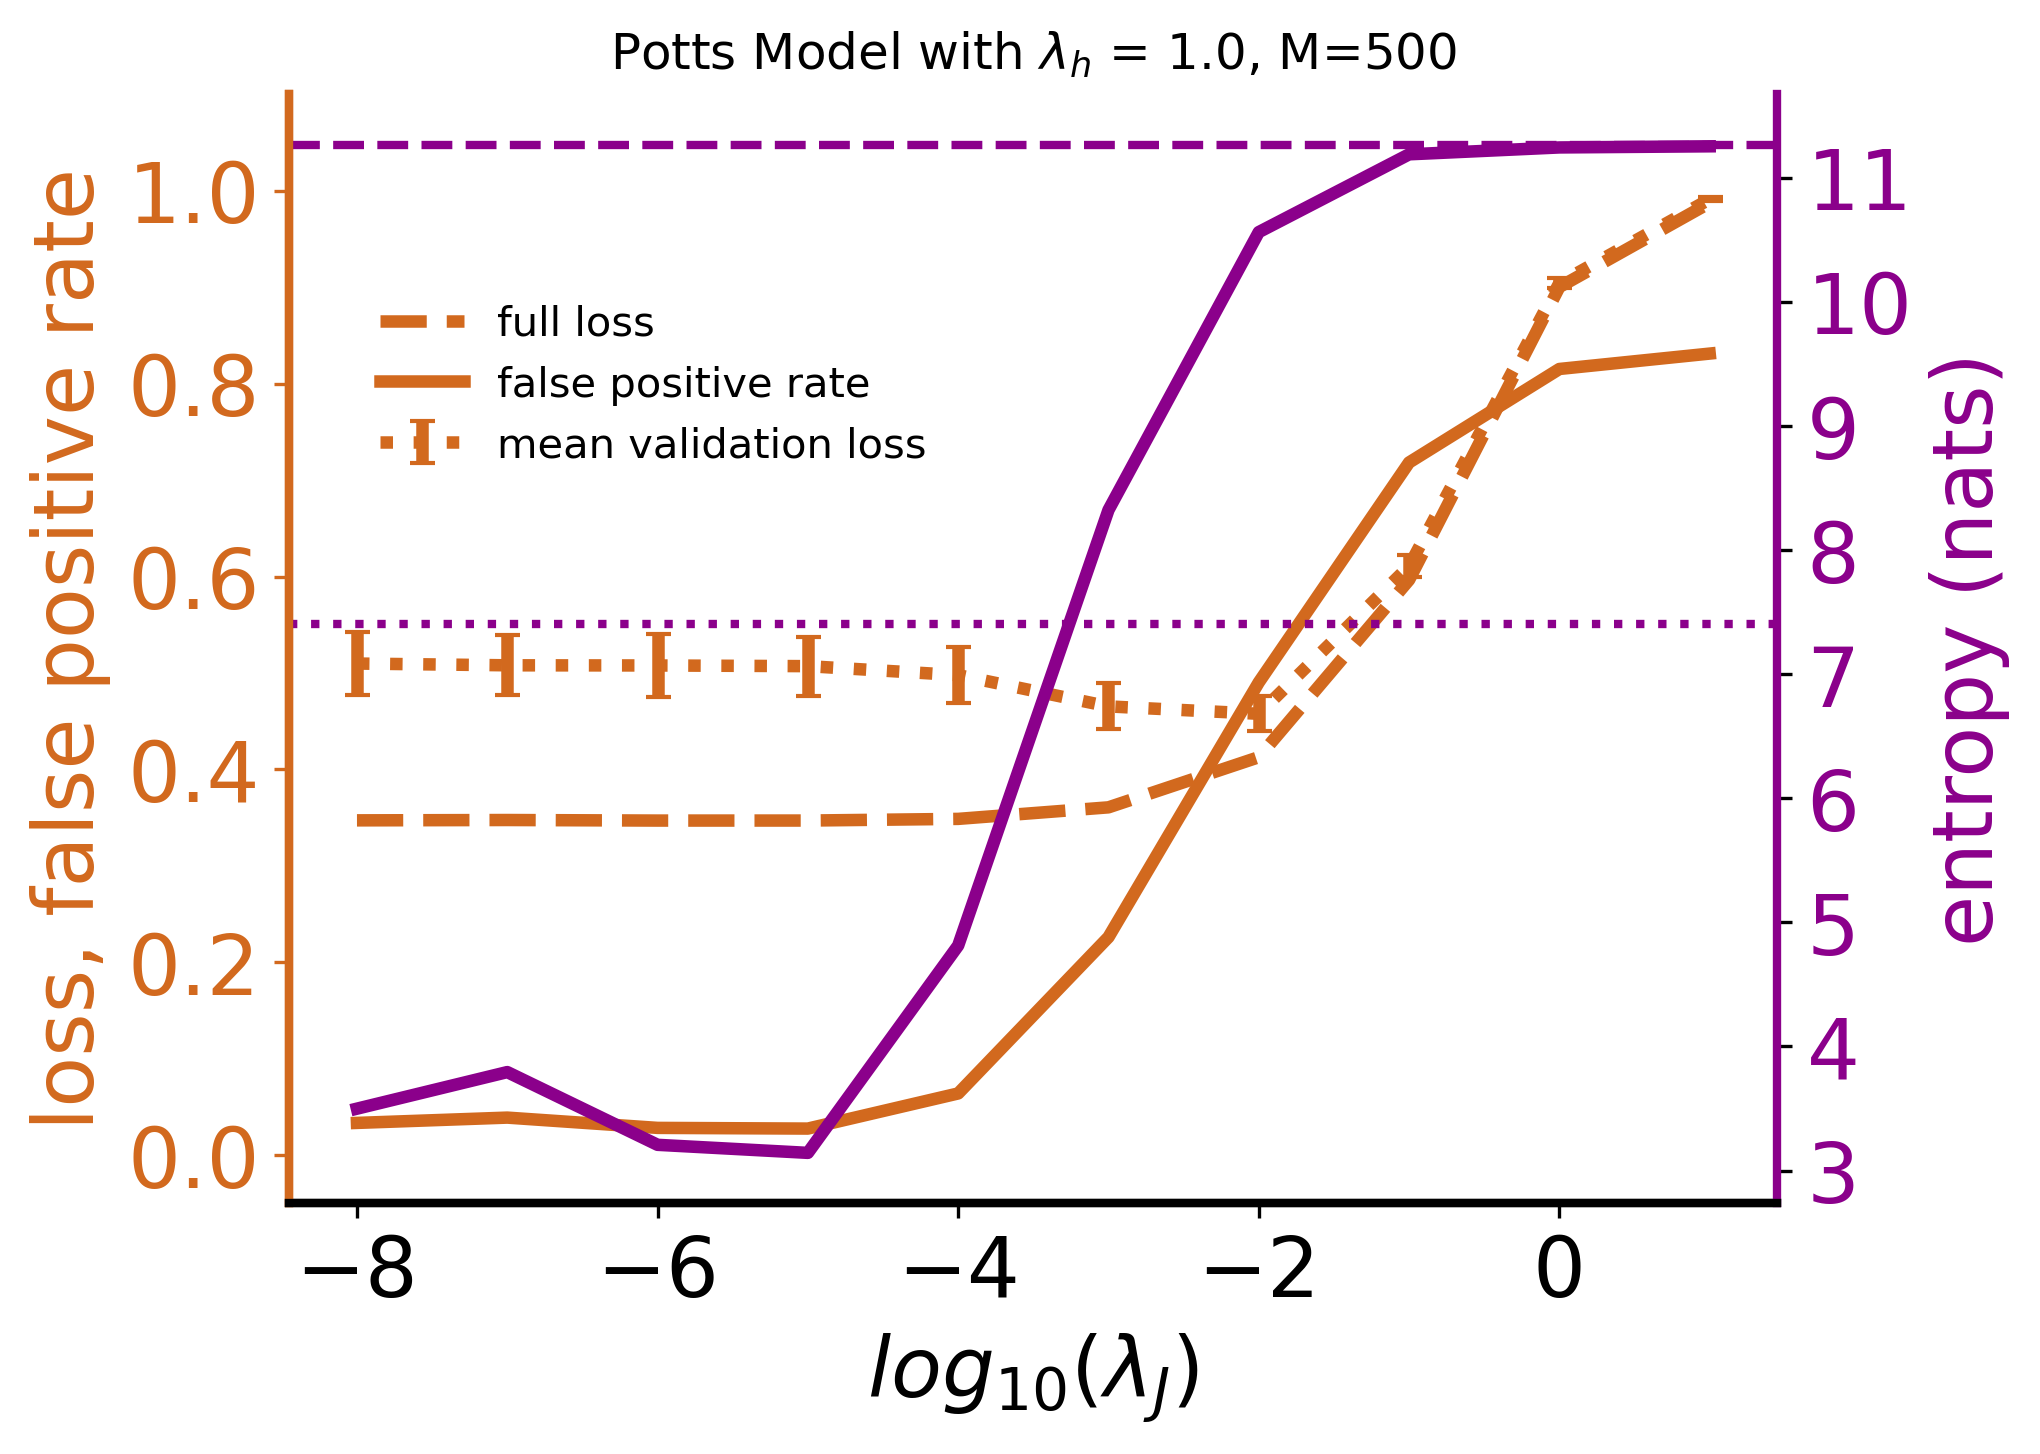

PyObject Text(0.5, 1.0, 'Potts Model with $ \\lambda_h$ = 1.0, M=500')

In [611]:
fig, ax = subplots(dpi=300)
rand_ent=7*log(5)
ylims =( -0.05,1.1 )

plot_losses( ax, losses_pw,  true , true, rand_ent, ylims)
ax.set_xlabel(L"log_{10}(\lambda_J)", fontsize=20)
title("Potts Model with "*L" \lambda_h"*" = $(best_pw_reg_h[1]), M=$(M)" )
# savefig(fitsdir("pairwise_learning_curve.png"))


# fig, ax = subplots(dpi=200)
# plot_losses( ax, losses_rbm, true, false, rand_ent )
# ax.set_xlabel(L"log_{10}(\lambda_W)")
# title("rbm with P = $best_rbm_P, lambda_h = $best_rbm_reg_h, M=$(M)")
# savefig(fitsdir("rbm_learning_curve.png"))

# temp dependance (sec)

In [612]:
params_sets = Dict{Symbol,Any}(
    :Pairwise => Dict{Symbol, Any}(
        :reg_J => [(10f0^log10λ, 2) for log10λ ∈ -2:-2],
        :reg_h => [(10f0^log10λ, 2) for log10λ ∈ 0:0],
        :epochs => 20_000,
        :showevery => 500,
        :progTol => 10^-6
    )
)
d = dict_list(params_sets[:Pairwise])[1] # validation minimum model

vecθ = BSON.load(fitsdir("Pairwise",(savename(d)*"_model.bson")))[:vecθ]
P = haskey(d, :P) ? d[:P] : 0
θ = initθ(:Pairwise, q, N, P )
copyto!(θ, vecθ);

In [613]:
nsamples_for_fpos = 10_000
θpw, θsec =  init_toy_model( Tsec )
q,N = (5,7)
all_states_buffer = (N*log(q)) < 21. ? AllStatesBuffer( q, N, θsec, θsec.FloatType ) : nothing
sec_energy_buffer = SectorEnergyBuffer( θsec , nsamples_for_fpos )
Htrue = H_toymodel( θpw, θsec )


Dict{Symbol, Any} with 4 entries:
  :Hisos  => 15.5483
  :Hnoise => 28.9699
  :Hsec   => 7.40194
  :Htotal => 51.9201

In [614]:
H = zeros(Float32, length(Tsamps))
f_pos = zeros(Float32, length(Tsamps))

Tsamps = collect(0.1:0.1:1)

for k in 1:length(Tsamps)
    θpw_seconly = Pairwise(θ.J./Tsamps[k], θ.h./Tsamps[k])
    f_pos[k], H[k] = get_f_pos_rate(θsec, θpw_seconly, sec_energy_buffer, all_states_buffer, M)
end



In [615]:
f_pos

10-element Vector{Float32}:
 2.9171074f-21
 1.1420103f-9
 1.40319025f-5
 0.001712366
 0.025824126
 0.11207147
 0.23504195
 0.34468198
 0.42819622
 0.49025142

In [616]:
H

10-element Vector{Float32}:
  0.7411518
  1.2852736
  1.5969992
  2.3688893
  4.2022567
  6.7141867
  8.626141
  9.689675
 10.250565
 10.563021

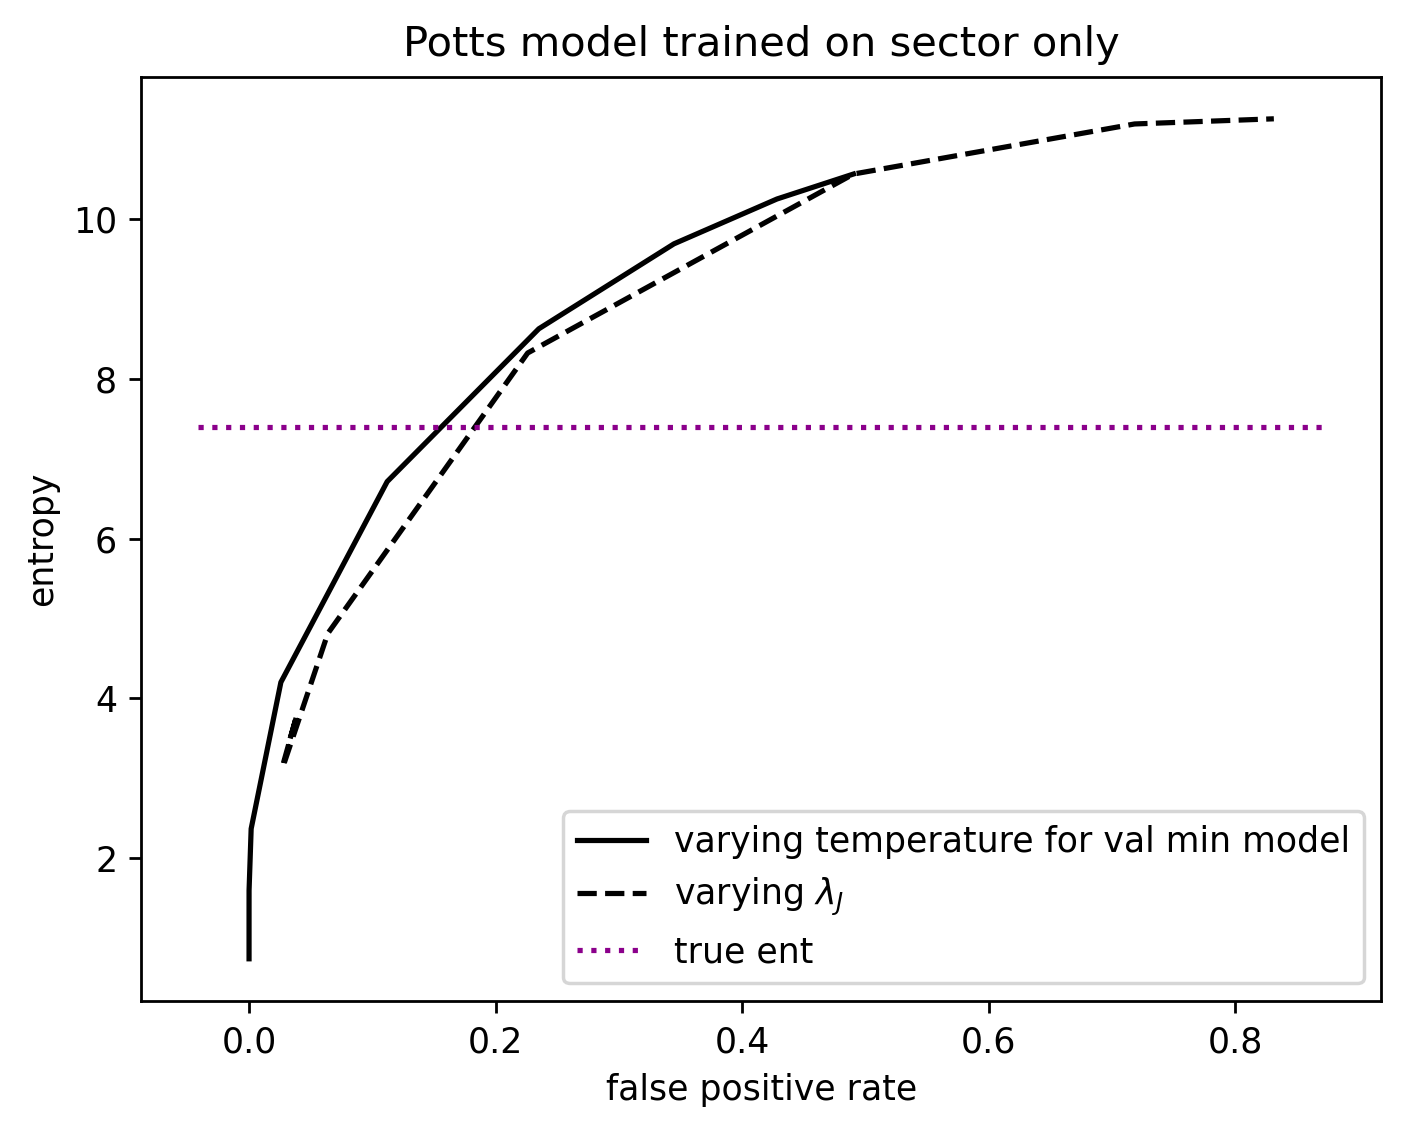

PyObject <matplotlib.legend.Legend object at 0x319e9f9a0>

In [617]:
fig, ax = subplots(dpi=250)
ents = H
plot(f_pos, ents, label="varying temperature for val min model", color="k")
xlabel("false positive rate")
ylabel("entropy")
plot(losses_pw[:,5] , losses_pw[:,6], label="varying "*L"\lambda_J", color="k", linestyle="dashed")
title("Potts model trained on sector only")
true_ent = H_toymodel(init_toy_model(Tsec)...)[:Hsec]
hlines(true_ent, ax.get_xlim()..., label="true ent", color="darkmagenta", linestyle="dotted")
legend()

In [505]:
exp.(7*log(5) - H_toymodel(init_toy_model(Tsec)...)[:Hsec])

47.66146138549282

In [501]:
exp.(7*log(5) .- losses_pw[:,end-1])

10-element Vector{Float64}:
 2362.3585625468872
 1759.0752185548354
 3161.5905785048476
 3373.349030933981
  634.4310023029336
   18.967733073479568
    2.0198952114268343
    1.0791581012362692
    1.0209997151666867
    1.0117517693307017

In [496]:
Bino(x, q, N) = binomial(N,x) * (1-(1/q))^x * (1/q)^(N-x) #prob of having x mutations from ideal pattern
Bino(x) = Bino(x, 5, 7)
cc = 0.0
for x in 4:7
    cc+=Bino(x)
end

In [497]:
cc

0.9666560000000005

In [33]:
zeros(5,5)

5×5 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0